# Setup env

In [185]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [186]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks')
print(os.getcwd())

/content/drive/My Drive/Colab Notebooks


# Toolbox

## Import

In [187]:
import math

from functools import reduce
from itertools import combinations

import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(output_distribution='normal')
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

from IPython.display import display, IFrame, HTML

## Utilities


In [188]:
SUFFIX_NORM = '_norm'

In [189]:
def percent(number, prec=2):
    return '{} %'.format(round(number*100, prec))

In [190]:
# list column names of specific type from dataframe
def getcols(data_frame, compare_type):
    return [col for col in data_frame if data_frame[col].dtype==compare_type]

# string columns
def scols(data_frame):
    return getcols(data_frame, compare_type=object)

# boolean columns
def bcols(data_frame):
    return getcols(data_frame, compare_type=bool)

# integer columns
def icols(data_frame):
    return getcols(data_frame, compare_type=np.int64)

# decimal columns
def fcols(data_frame):
    return getcols(data_frame, compare_type=np.float64)

# categorical columns
def catcols(data_frame):
    return scols(data_frame) + bcols(data_frame)

# numeric columns
def numcols(data_frame, norm_only=False):
    cols = icols(data_frame) + fcols(data_frame)
    if norm_only:
      cols = [col for col in cols if col[-len(SUFFIX_NORM):]==SUFFIX_NORM]
    return cols

In [191]:
# filter rows with all unknown columns
def all_nan_cols(data_frame):
    return data_frame[data_frame.isnull().all(axis=1)]

# filter rows with at least 1 unknown column
def any_nan_cols(data_frame):
    return data_frame[data_frame.isnull().any(axis=1)]

# filter rows with no unknown columns
def no_nan_cols(data_frame):
    return data_frame[data_frame.notnull().all(axis=1)]

In [192]:
def transform_to_norm(series):
  return qt.fit_transform(series.values.reshape(-1, 1))

In [193]:
def describeframe(dframe):
  display(dframe.head())
  dframe.info()
  display(dframe.describe(percentiles=[.001,.005,.01,.05,0.1,.25,.5,.75,.9,.95,.99,.995,.999], include='all'))
  print('Standard error')
  display(dframe[numcols(dframe)].sem())
  print('Coefficient of variation')
  display(dframe[numcols(dframe)].std() / dframe[numcols(dframe)].mean() * 100)
  print('Range')
  display(dframe[numcols(dframe)].max() - dframe[numcols(dframe)].min())
  print('Interquartile range')
  display(dframe[numcols(dframe)].quantile(.75) - dframe[numcols(dframe)].quantile(.25))
  print('Skewness')
  display(dframe[numcols(dframe)].skew())
  print('Curtosis')
  display(dframe[numcols(dframe)].kurtosis())

In [194]:
PVALUE_TRESHOLD = .05

def is_normal(dframe, colname):
  _, pvalue = stats.normaltest(dframe[colname], nan_policy='omit')
  print(colname)
  print("null hypothesis: sample comes from a normal distribution")
  print("2-sided chi squared probability: ", pvalue)
  if (pvalue < PVALUE_TRESHOLD):
    print("null hypothesis rejected: is NOT a normal distribution")
  else:
    print("null hypothesis not rejected")

## Plotting

In [195]:
# histogram
def hist(series, title=None, bins=50):
    plt.figure(figsize=(10,5))
    #series.plot(kind='hist', bins=bins, title=title)
    sns.distplot(series, bins=bins, axlabel=title)
    plt.show()
    plt.close()
    
# box plot
def box(series, title=None):
    plt.figure(figsize=(10,5))
    sns.boxplot(series).set_title(title)
    plt.show()
    plt.close()

# violin plot
def violin(series):
    plt.figure()
    sns.violinplot(series)
    plt.show()
    plt.close()

# q-q plot
def qqplot(series, title=None):
    plt.figure(figsize=[5,5])
    stats.probplot(series, plot=plt); # default is normal distribution
    plt.title(title)
    plt.show()
    plt.close()
    
# series of plots for continuous variables
def contplot(series, bins=50, title=None):
    if not title:
      title = series.name
    hist(series, title=title, bins=bins)
    box(series)
    violin(series)
    qqplot(series)

# bar chart
def bar(series, title=None, orientation='vertical', figsize=None):
  if figsize:
    plt.figure(figsize=figsize)
  else:
    plt.figure()
  kind = 'barh' if orientation is 'horizontal' else 'bar'
  ax = series.value_counts().plot(kind=kind, title=title)
  for p in ax.patches:
      # Annotate each bar with value count
      ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))
  plt.ylabel('value count')
  plt.tight_layout()
  plt.show()
  plt.close()

# scatter plot
def scatter(series_x, series_y, color_series=None, figsize=None):
    if figsize:
      plt.figure(figsize=figsize)
    else:
      plt.figure(figsize=[8,8])
    plt.scatter(series_x, series_y, s=7, alpha=.5, label=None, c=color_series)
    plt.xlabel(series_x.name)
    plt.ylabel(series_y.name)
    plt.show()
    plt.close()

# heatmap
def hm(frame, xlabels=True, ylabels=True, title=None): 
    plt.figure(figsize=[10,10])
    sns.heatmap(frame, cmap='seismic', xticklabels=xlabels, yticklabels=ylabels, square=True)
    plt.xticks(rotation=60)
    plt.title(title)
    plt.show()
    plt.close

# Preprocess: Load

## Dataset

Data source: [World Health Statistics 2020](https://www.kaggle.com/utkarshxy/who-worldhealth-statistics-2020-complete)

We chose dataset with the aim discover relations between various health statistics and mortality worldwide.  
We analyze following columns.

tob : Tobacco : Age-standardized prevalence of current tobacco smoking among persons aged 15 years and older  
alc : Alcohol : Total (recorded+unrecorded) alcohol per capita (15+) consumption  
wat : Water : Population using at least basic drinking-water services (%)  
poi : Poison : Mortality rate attributed to unintentional poisoning (per 100 000 population)  
dea : Death : Probability (%) of dying between age 30 and exact age 70 from any of cardiovascular disease, cancer, diabetes, or chronic respiratory disease  
han : Handwash : Population with basic handwashing facilities at home (%) 

In [196]:
df_tob = pd.read_csv('data/tobaccoAge15.csv')
df_alc = pd.read_csv('data/alcoholSubstanceAbuse.csv')
df_wat = pd.read_csv('data/basicDrinkingWaterServices.csv')
df_poi = pd.read_csv('data/mortalityRatePoisoning.csv')
df_dea = pd.read_csv('data/30-70cancerChdEtc.csv')
df_han = pd.read_csv('data/basicHandWashing.csv')

In [197]:
dframes = [df_tob, df_alc, df_wat, df_poi, df_dea, df_han]
for dframe in dframes:
  display(dframe)

,Location,Indicator,Period,Dim1,First Tooltip
0,Albania,Age-standardized prevalence of current tobacco...,2018,Both sexes,29.2
1,Albania,Age-standardized prevalence of current tobacco...,2018,Male,50.5
2,Albania,Age-standardized prevalence of current tobacco...,2018,Female,7.9
3,Albania,Age-standardized prevalence of current tobacco...,2017,Both sexes,29.3
4,Albania,Age-standardized prevalence of current tobacco...,2017,Male,50.6
...,...,...,...,...,...
4018,Zimbabwe,Age-standardized prevalence of current tobacco...,2005,Male,31.6
4019,Zimbabwe,Age-standardized prevalence of current tobacco...,2005,Female,2.3
4020,Zimbabwe,Age-standardized prevalence of current tobacco...,2000,Both sexes,18.3
4021,Zimbabwe,Age-standardized prevalence of current tobacco...,2000,Male,33.7


,Location,Period,Indicator,Dim1,First Tooltip
0,Afghanistan,2018,Total (recorded+unrecorded) alcohol per capita...,Both sexes,0.210
1,Afghanistan,2018,Total (recorded+unrecorded) alcohol per capita...,Male,0.360
2,Afghanistan,2018,Total (recorded+unrecorded) alcohol per capita...,Female,0.055
3,Afghanistan,2015,Total (recorded+unrecorded) alcohol per capita...,Both sexes,0.210
4,Afghanistan,2015,Total (recorded+unrecorded) alcohol per capita...,Male,0.350
...,...,...,...,...,...
2782,Zimbabwe,2005,Total (recorded+unrecorded) alcohol per capita...,Male,4.720
2783,Zimbabwe,2005,Total (recorded+unrecorded) alcohol per capita...,Female,0.990
2784,Zimbabwe,2000,Total (recorded+unrecorded) alcohol per capita...,Both sexes,2.460
2785,Zimbabwe,2000,Total (recorded+unrecorded) alcohol per capita...,Male,4.160


,Location,Period,Indicator,First Tooltip
0,Afghanistan,2017,Population using at least basic drinking-water...,57.32
1,Afghanistan,2016,Population using at least basic drinking-water...,54.84
2,Afghanistan,2015,Population using at least basic drinking-water...,52.39
3,Afghanistan,2014,Population using at least basic drinking-water...,49.96
4,Afghanistan,2013,Population using at least basic drinking-water...,47.56
...,...,...,...,...
3450,Zimbabwe,2004,Population using at least basic drinking-water...,57.94
3451,Zimbabwe,2003,Population using at least basic drinking-water...,58.59
3452,Zimbabwe,2002,Population using at least basic drinking-water...,59.23
3453,Zimbabwe,2001,Population using at least basic drinking-water...,59.88


,Location,Indicator,Period,Dim1,First Tooltip
0,Afghanistan,Mortality rate attributed to unintentional poi...,2016,Both sexes,1.19
1,Afghanistan,Mortality rate attributed to unintentional poi...,2016,Male,0.53
2,Afghanistan,Mortality rate attributed to unintentional poi...,2016,Female,1.89
3,Afghanistan,Mortality rate attributed to unintentional poi...,2015,Both sexes,1.22
4,Afghanistan,Mortality rate attributed to unintentional poi...,2015,Male,0.55
...,...,...,...,...,...
2740,Zimbabwe,Mortality rate attributed to unintentional poi...,2005,Male,2.85
2741,Zimbabwe,Mortality rate attributed to unintentional poi...,2005,Female,2.62
2742,Zimbabwe,Mortality rate attributed to unintentional poi...,2000,Both sexes,3.44
2743,Zimbabwe,Mortality rate attributed to unintentional poi...,2000,Male,3.75


,Location,Period,Indicator,Dim1,First Tooltip
0,Afghanistan,2016,Probability (%) of dying between age 30 and ex...,Both sexes,29.8
1,Afghanistan,2016,Probability (%) of dying between age 30 and ex...,Male,31.8
2,Afghanistan,2016,Probability (%) of dying between age 30 and ex...,Female,27.7
3,Afghanistan,2015,Probability (%) of dying between age 30 and ex...,Both sexes,29.8
4,Afghanistan,2015,Probability (%) of dying between age 30 and ex...,Male,31.9
...,...,...,...,...,...
2740,Zimbabwe,2005,Probability (%) of dying between age 30 and ex...,Male,22.1
2741,Zimbabwe,2005,Probability (%) of dying between age 30 and ex...,Female,22.9
2742,Zimbabwe,2000,Probability (%) of dying between age 30 and ex...,Both sexes,21.6
2743,Zimbabwe,2000,Probability (%) of dying between age 30 and ex...,Male,21.6


,Location,Indicator,Period,Dim1,First Tooltip
0,Afghanistan,Population with basic handwashing facilities a...,2017,Total,37.75
1,Afghanistan,Population with basic handwashing facilities a...,2017,Urban,63.58
2,Afghanistan,Population with basic handwashing facilities a...,2017,Rural,29.02
3,Afghanistan,Population with basic handwashing facilities a...,2016,Total,37.67
4,Afghanistan,Population with basic handwashing facilities a...,2016,Urban,63.58
...,...,...,...,...,...
2721,Zimbabwe,Population with basic handwashing facilities a...,2012,Urban,48.54
2722,Zimbabwe,Population with basic handwashing facilities a...,2012,Rural,31.20
2723,Zimbabwe,Population with basic handwashing facilities a...,2011,Total,36.93
2724,Zimbabwe,Population with basic handwashing facilities a...,2011,Urban,48.54


In [198]:
for dframe in dframes:
  for col in ['Location','Period','Indicator','Dim1']:
    if col in dframe.columns:
      display(dframe[col].unique())

array(['Albania', 'Algeria', 'Andorra', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain',
       'Bangladesh', 'Barbados', 'Belarus', 'Belgium', 'Benin',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Brunei Darussalam', 'Bulgaria', 'Burkina Faso', 'Burundi',
       'Cambodia', 'Cameroon', 'Canada', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica',
       'Côte d’Ivoire', 'Croatia', 'Cuba', 'Cyprus', 'Czechia',
       "Democratic People's Republic of Korea", 'Denmark',
       'Dominican Republic', 'Egypt', 'El Salvador', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gambia',
       'Georgia', 'Germany', 'Ghana', 'Greece', 'Guyana', 'Haiti',
       'Hungary', 'Iceland', 'India', 'Indonesia',
       'Iran (Islamic Republic of)', 'Iraq', 'Ireland', 'Israel', 'Italy',
       'Jamaica', 'Japan', 'Kazakhstan', 'Kenya', 'Kiribati', 'Kuwait',
       'Kyrgyz

array([2018, 2017, 2016, 2015, 2014, 2013, 2010, 2005, 2000])

array(['Age-standardized prevalence of current tobacco smoking among persons aged 15 years and older'],
      dtype=object)

array(['Both sexes', 'Male', 'Female'], dtype=object)

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo', 'Costa Rica', 'Côte d’Ivoire',
       'Croatia', 'Cuba', 'Cyprus', 'Czechia',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia', 'Georgia', 'G

array([2018, 2015, 2010, 2005, 2000])

array(['Total (recorded+unrecorded) alcohol per capita (15+) consumption'],
      dtype=object)

array(['Both sexes', 'Male', 'Female'], dtype=object)

array(['Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo', 'Cook Islands', 'Costa Rica',
       'Côte d’Ivoire', 'Croatia', 'Cuba', 'Cyprus', 'Czechia',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Denmark', 'Djibouti',
       'Dominica', 'Dominican Republic', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Fiji', 'Finland', 'France', 'Gabon',
       'Gambia

array([2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007,
       2006, 2005, 2004, 2003, 2002, 2001, 2000])

array(['Population using at least basic drinking-water services (%)'],
      dtype=object)

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo', 'Costa Rica', 'Côte d’Ivoire',
       'Croatia', 'Cuba', 'Cyprus', 'Czechia',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Denmark', 'Djibouti',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia',
       'Germany', 'Ghana', 'Gree

array([2016, 2015, 2010, 2005, 2000])

array(['Mortality rate attributed to unintentional poisoning (per 100 000 population)'],
      dtype=object)

array(['Both sexes', 'Male', 'Female'], dtype=object)

array(['Afghanistan', 'Albania', 'Algeria', 'Angola',
       'Antigua and Barbuda', 'Argentina', 'Armenia', 'Australia',
       'Austria', 'Azerbaijan', 'Bahamas', 'Bahrain', 'Bangladesh',
       'Barbados', 'Belarus', 'Belgium', 'Belize', 'Benin', 'Bhutan',
       'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina',
       'Botswana', 'Brazil', 'Brunei Darussalam', 'Bulgaria',
       'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cambodia', 'Cameroon',
       'Canada', 'Central African Republic', 'Chad', 'Chile', 'China',
       'Colombia', 'Comoros', 'Congo', 'Costa Rica', 'Côte d’Ivoire',
       'Croatia', 'Cuba', 'Cyprus', 'Czechia',
       "Democratic People's Republic of Korea",
       'Democratic Republic of the Congo', 'Denmark', 'Djibouti',
       'Dominican Republic', 'Ecuador', 'Egypt', 'El Salvador',
       'Equatorial Guinea', 'Eritrea', 'Estonia', 'Eswatini', 'Ethiopia',
       'Fiji', 'Finland', 'France', 'Gabon', 'Gambia', 'Georgia',
       'Germany', 'Ghana', 'Gree

array([2016, 2015, 2010, 2005, 2000])

array(['Probability (%) of dying between age 30 and exact age 70 from any of cardiovascular disease, cancer, diabetes, or chronic respiratory disease'],
      dtype=object)

array(['Both sexes', 'Male', 'Female'], dtype=object)

array(['Afghanistan', 'Algeria', 'Angola', 'Armenia', 'Azerbaijan',
       'Bangladesh', 'Barbados', 'Belize', 'Benin', 'Bhutan',
       'Bolivia (Plurinational State of)', 'Bosnia and Herzegovina',
       'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Central African Republic', 'Chad', 'Colombia', 'Comoros', 'Congo',
       'Costa Rica', 'Côte d’Ivoire', 'Cuba',
       'Democratic Republic of the Congo', 'Dominican Republic',
       'Ecuador', 'Egypt', 'El Salvador', 'Equatorial Guinea', 'Eswatini',
       'Ethiopia', 'Gambia', 'Ghana', 'Guatemala', 'Guinea',
       'Guinea-Bissau', 'Guyana', 'Haiti', 'Honduras', 'India',
       'Indonesia', 'Iraq', 'Jamaica', 'Kazakhstan', 'Kenya',
       'Kyrgyzstan', "Lao People's Democratic Republic", 'Lesotho',
       'Liberia', 'Madagascar', 'Malawi', 'Maldives', 'Mali',
       'Marshall Islands', 'Mauritania', 'Mexico', 'Mongolia',
       'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'Niger', 'Nigeria',
       'Oman', 'Pakistan', 'Pa

array([2017, 2016, 2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007,
       2006, 2005, 2004, 2003, 2002, 2001, 2000])

array(['Population with basic handwashing facilities at home (%)'],
      dtype=object)

array(['Total', 'Urban', 'Rural'], dtype=object)

No nonsense detected.

In [199]:
countries = []
for dframe in dframes:
  for col in ['Location']:
    countries = countries + list(dframe[col].unique())
display(set(countries))

{'Afghanistan',
 'Albania',
 'Algeria',
 'Andorra',
 'Angola',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bhutan',
 'Bolivia (Plurinational State of)',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cabo Verde',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Central African Republic',
 'Chad',
 'Chile',
 'China',
 'Colombia',
 'Comoros',
 'Congo',
 'Cook Islands',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Cyprus',
 'Czechia',
 'Côte d’Ivoire',
 "Democratic People's Republic of Korea",
 'Democratic Republic of the Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Eswatini',
 'Ethiopia',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Georgia',
 'Germany',
 'Ghana',
 'Greece',

No country names duplicates.

For each file, we are interested in Location, Year, Gender, and of course the value of the parameter.  
Some files do not contain data for both genders, we assume genders were represented equally.

In [200]:
df_tob.rename(columns = {'First Tooltip':'Tobacco'}, inplace = True)
df_alc.rename(columns = {'First Tooltip':'Alcohol'}, inplace = True)
df_wat.rename(columns = {'First Tooltip':'Water'}, inplace = True)
df_poi.rename(columns = {'First Tooltip':'Poison'}, inplace = True)
df_dea.rename(columns = {'First Tooltip':'Death'}, inplace = True)
df_han.rename(columns = {'First Tooltip':'Handwash'}, inplace = True)

df_han.rename(columns = {'Dim1':'Area'}, inplace = True)
df_han.drop(df_han[df_han['Area'] != 'Total'].index, inplace=True)
df_han.drop('Area', axis=1, inplace=True)

df_wat['Gender'] = 'Both sexes'
df_han['Gender'] = 'Both sexes'

for dframe in dframes:
  dframe.rename(columns = {'Period':'Year'}, inplace = True)
  dframe['Year'] = dframe['Year'].astype(str)

  dframe.rename(columns = {'Dim1':'Gender'}, inplace = True)

  dframe.drop('Indicator', axis=1, inplace=True)

  display(dframe)

,Location,Year,Gender,Tobacco
0,Albania,2018,Both sexes,29.2
1,Albania,2018,Male,50.5
2,Albania,2018,Female,7.9
3,Albania,2017,Both sexes,29.3
4,Albania,2017,Male,50.6
...,...,...,...,...
4018,Zimbabwe,2005,Male,31.6
4019,Zimbabwe,2005,Female,2.3
4020,Zimbabwe,2000,Both sexes,18.3
4021,Zimbabwe,2000,Male,33.7


,Location,Year,Gender,Alcohol
0,Afghanistan,2018,Both sexes,0.210
1,Afghanistan,2018,Male,0.360
2,Afghanistan,2018,Female,0.055
3,Afghanistan,2015,Both sexes,0.210
4,Afghanistan,2015,Male,0.350
...,...,...,...,...
2782,Zimbabwe,2005,Male,4.720
2783,Zimbabwe,2005,Female,0.990
2784,Zimbabwe,2000,Both sexes,2.460
2785,Zimbabwe,2000,Male,4.160


,Location,Year,Water,Gender
0,Afghanistan,2017,57.32,Both sexes
1,Afghanistan,2016,54.84,Both sexes
2,Afghanistan,2015,52.39,Both sexes
3,Afghanistan,2014,49.96,Both sexes
4,Afghanistan,2013,47.56,Both sexes
...,...,...,...,...
3450,Zimbabwe,2004,57.94,Both sexes
3451,Zimbabwe,2003,58.59,Both sexes
3452,Zimbabwe,2002,59.23,Both sexes
3453,Zimbabwe,2001,59.88,Both sexes


,Location,Year,Gender,Poison
0,Afghanistan,2016,Both sexes,1.19
1,Afghanistan,2016,Male,0.53
2,Afghanistan,2016,Female,1.89
3,Afghanistan,2015,Both sexes,1.22
4,Afghanistan,2015,Male,0.55
...,...,...,...,...
2740,Zimbabwe,2005,Male,2.85
2741,Zimbabwe,2005,Female,2.62
2742,Zimbabwe,2000,Both sexes,3.44
2743,Zimbabwe,2000,Male,3.75


,Location,Year,Gender,Death
0,Afghanistan,2016,Both sexes,29.8
1,Afghanistan,2016,Male,31.8
2,Afghanistan,2016,Female,27.7
3,Afghanistan,2015,Both sexes,29.8
4,Afghanistan,2015,Male,31.9
...,...,...,...,...
2740,Zimbabwe,2005,Male,22.1
2741,Zimbabwe,2005,Female,22.9
2742,Zimbabwe,2000,Both sexes,21.6
2743,Zimbabwe,2000,Male,21.6


,Location,Year,Handwash,Gender
0,Afghanistan,2017,37.75,Both sexes
3,Afghanistan,2016,37.67,Both sexes
6,Afghanistan,2015,37.59,Both sexes
9,Afghanistan,2014,37.52,Both sexes
12,Afghanistan,2013,37.44,Both sexes
...,...,...,...,...
2711,Zimbabwe,2015,36.82,Both sexes
2714,Zimbabwe,2014,36.84,Both sexes
2717,Zimbabwe,2013,36.86,Both sexes
2720,Zimbabwe,2012,36.89,Both sexes


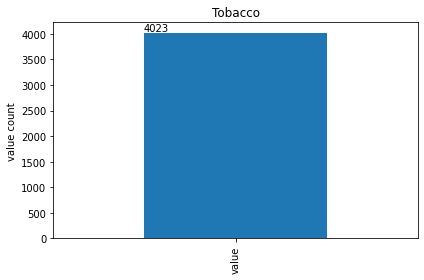

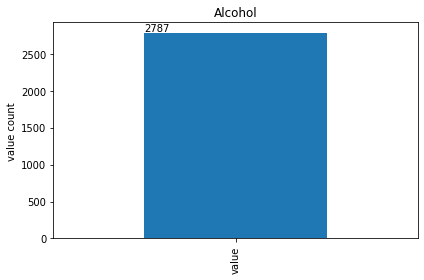

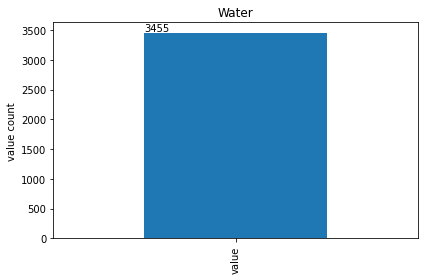

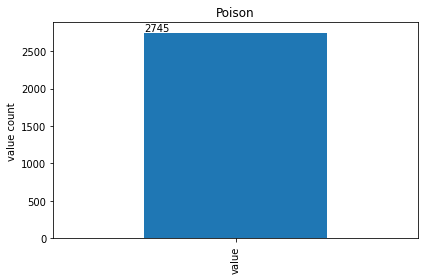

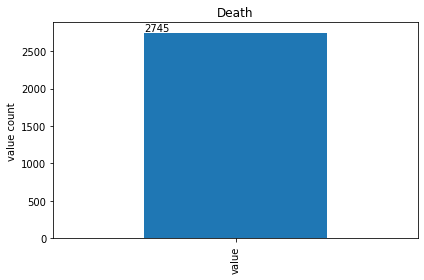

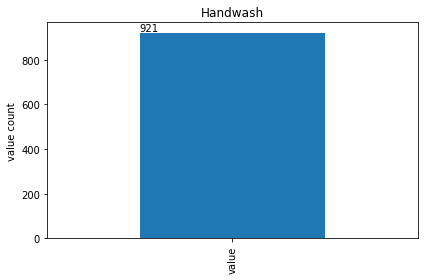

In [201]:
for dframe in dframes:
  for col in numcols(dframe):
    bar(dframe[col].apply(lambda x: 'NaN' if pd.isnull(x) else 'value'), title=col)

Original files do not contain missing values.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


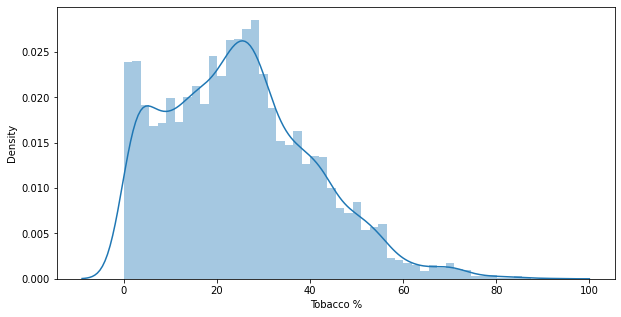

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


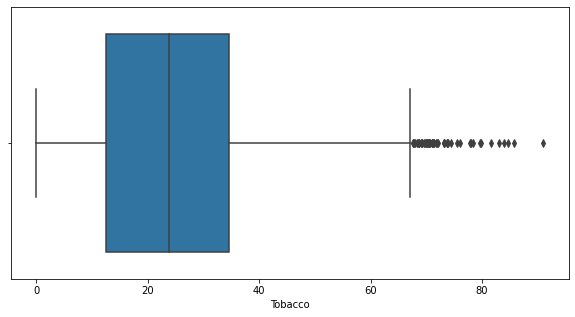

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


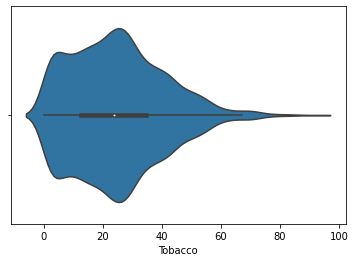

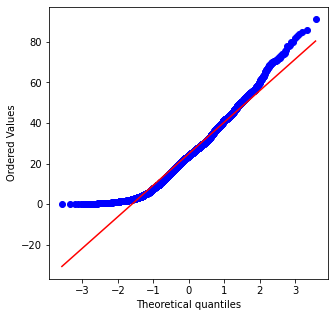

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


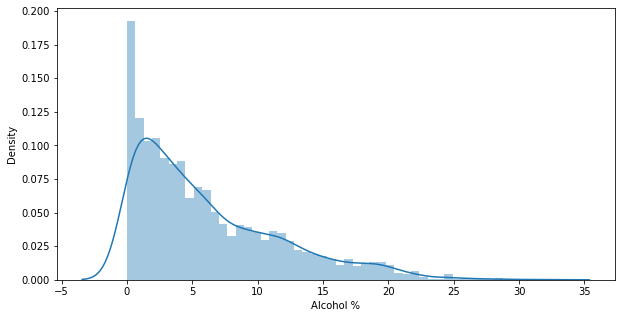

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


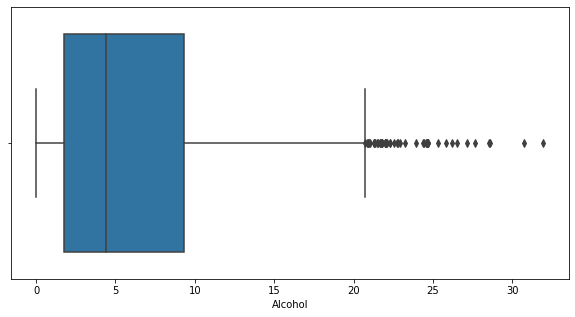

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


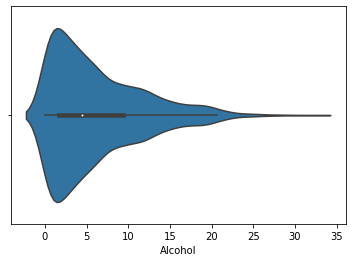

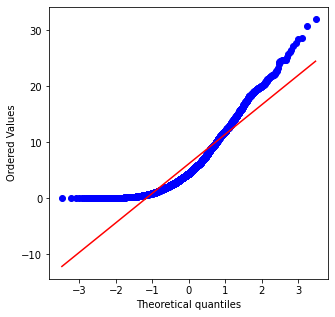

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


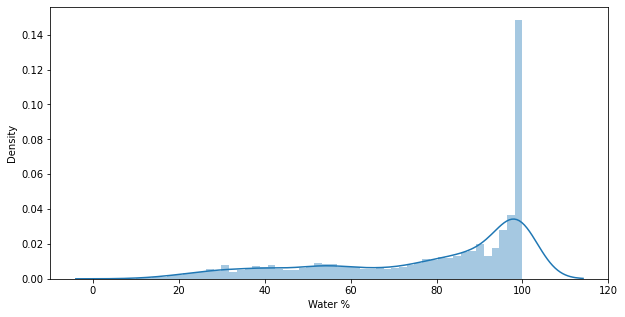

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


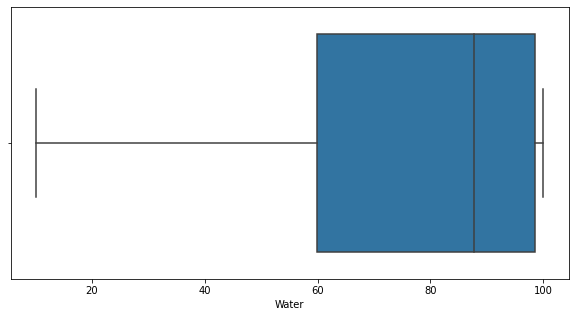

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


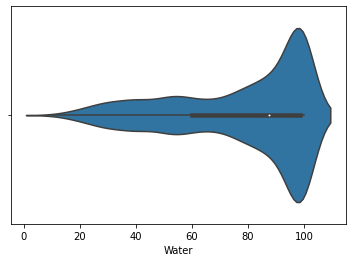

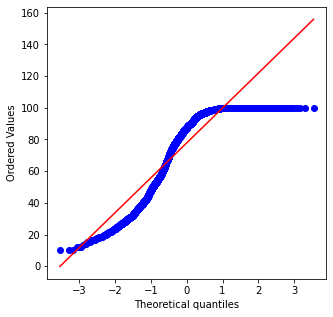

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


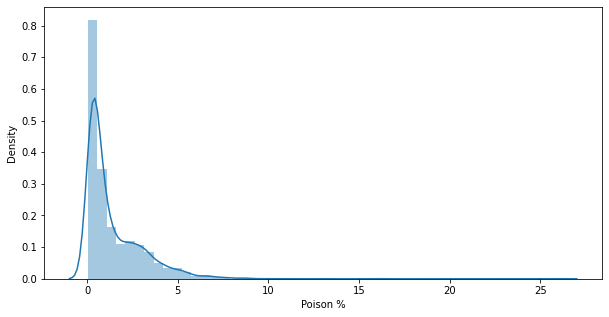

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


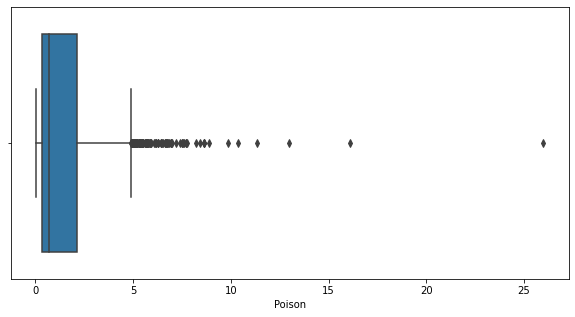

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


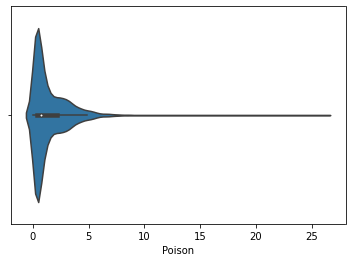

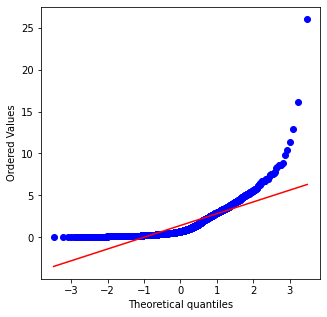

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


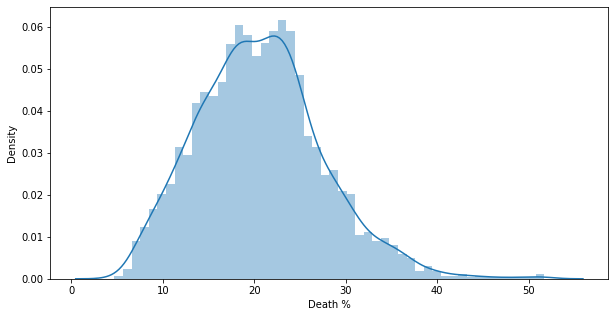

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


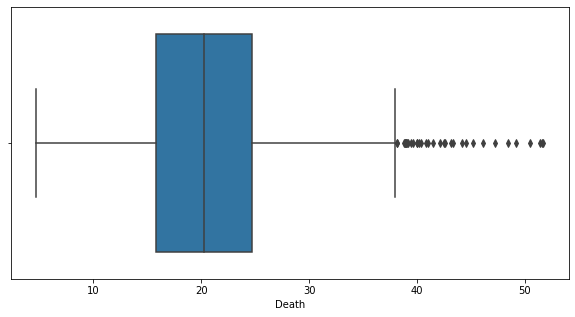

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


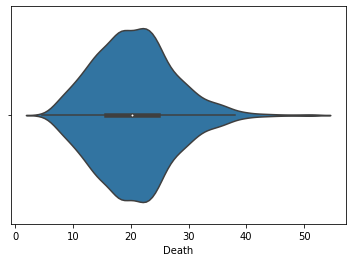

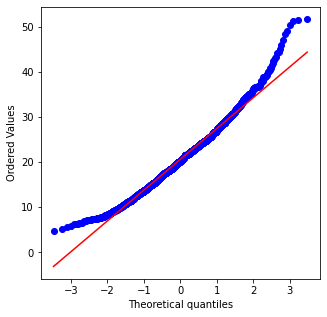

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


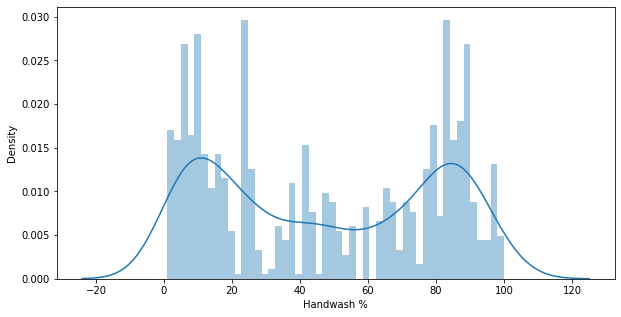

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


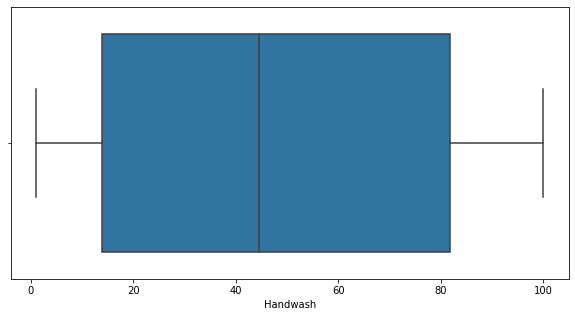

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


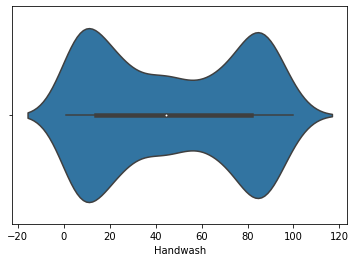

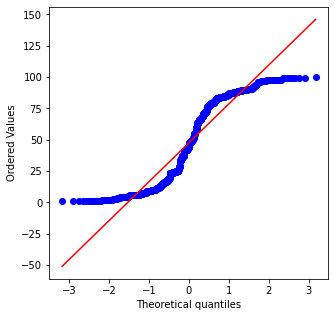

In [202]:
for dframe in dframes:
  for col in numcols(dframe):
    contplot(dframe[col], title=col + " %")

The more access to drinking water and handwashing facilities, the higher the value in %. We want reversed indicator, thus we transform to complement %.

In [203]:
df_wat['Water'] = df_wat['Water'].apply(lambda x: 100. - x)
df_han['Handwash'] = df_han['Handwash'].apply(lambda x: 100. - x)

In [204]:
for dframe in dframes:
  for col in numcols(dframe):
    is_normal(dframe, col)

Tobacco
null hypothesis: sample comes from a normal distribution
2-sided chi squared probability:  1.4350624960004805e-44
null hypothesis rejected: is NOT a normal distribution
Alcohol
null hypothesis: sample comes from a normal distribution
2-sided chi squared probability:  1.6804474523312334e-99
null hypothesis rejected: is NOT a normal distribution
Water
null hypothesis: sample comes from a normal distribution
2-sided chi squared probability:  2.3661698169189312e-88
null hypothesis rejected: is NOT a normal distribution
Poison
null hypothesis: sample comes from a normal distribution
2-sided chi squared probability:  0.0
null hypothesis rejected: is NOT a normal distribution
Death
null hypothesis: sample comes from a normal distribution
2-sided chi squared probability:  1.1148055391085959e-31
null hypothesis rejected: is NOT a normal distribution
Handwash
null hypothesis: sample comes from a normal distribution
2-sided chi squared probability:  0.0
null hypothesis rejected: is NOT a 

None of variables follows normal distribution. Thus we transform numeric columns into normal distribution.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


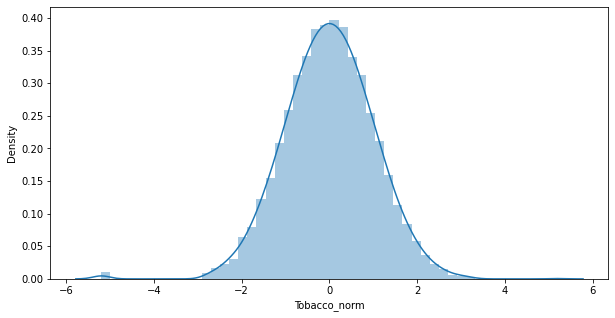

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


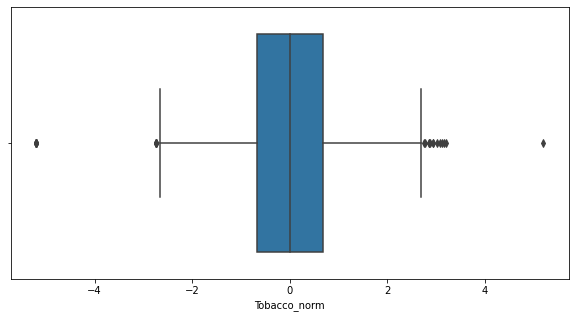

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


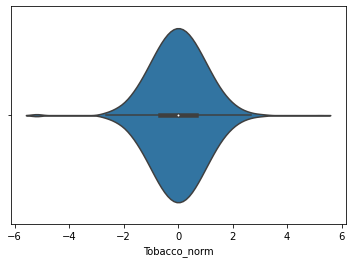

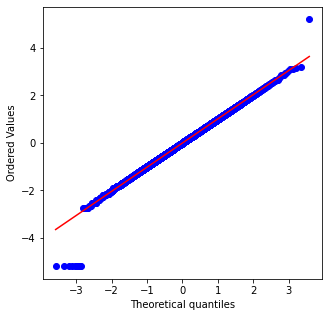

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


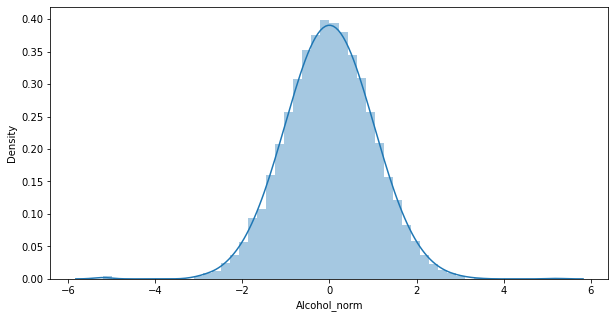

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


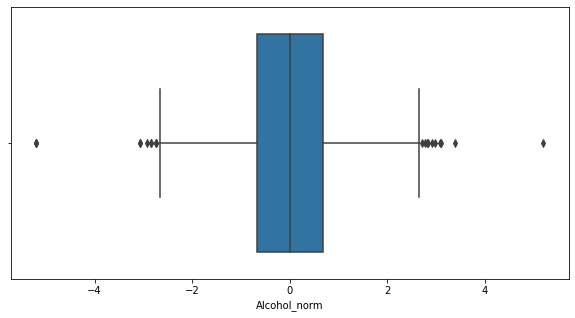

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


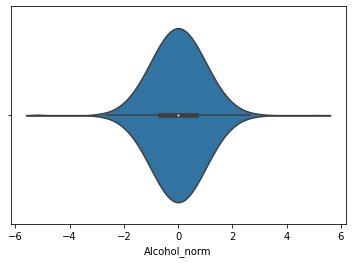

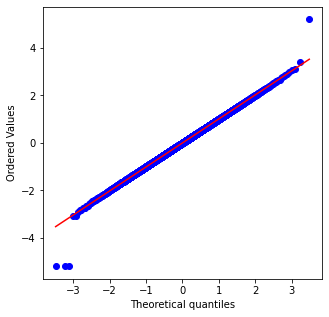

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


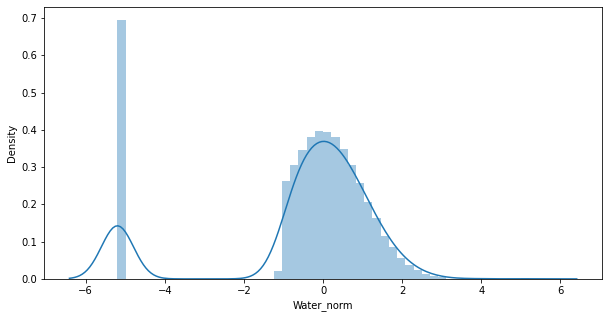

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


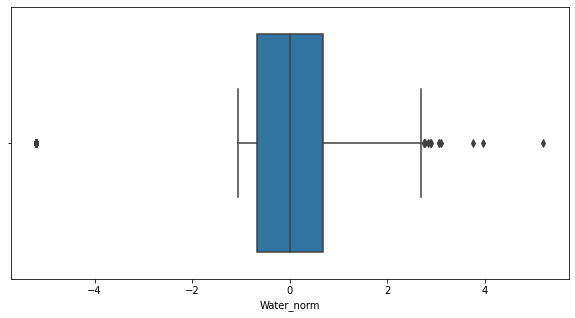

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


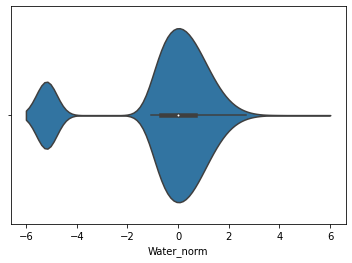

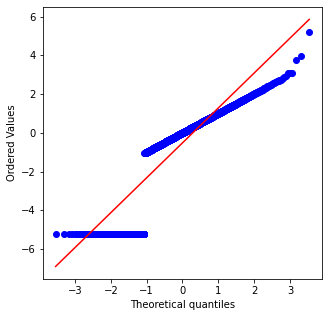

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


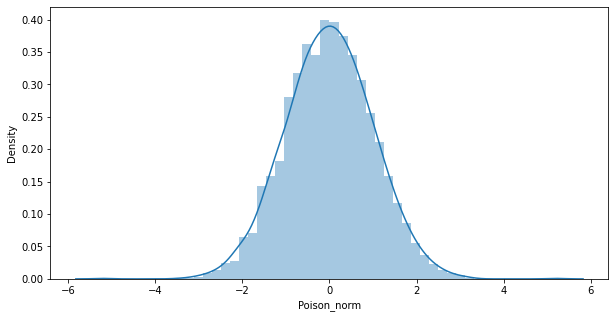

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


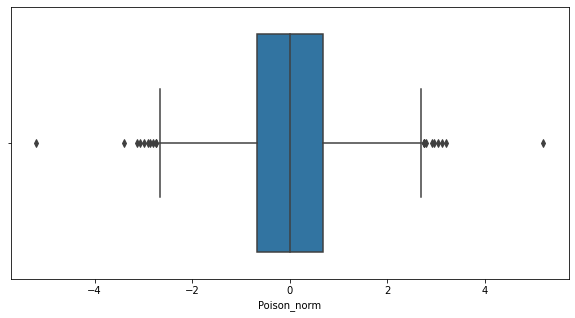

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


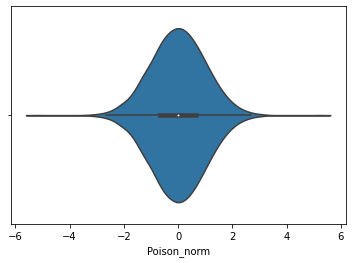

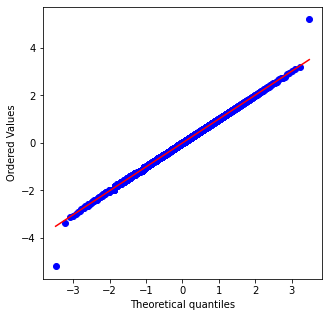

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


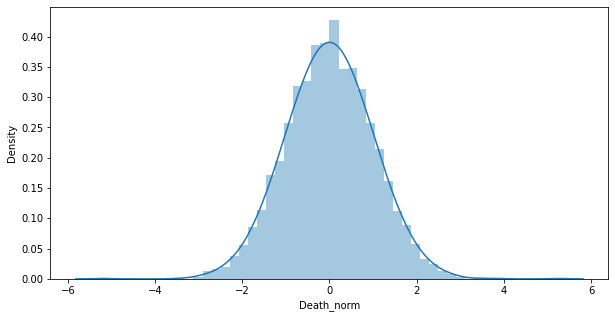

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


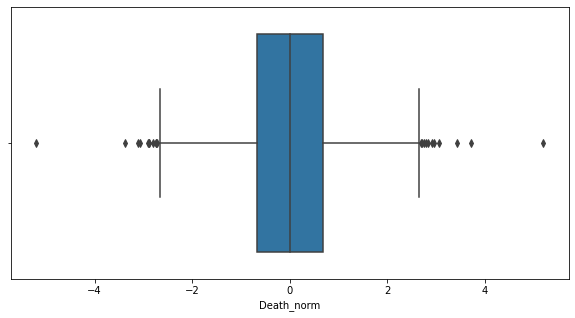

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


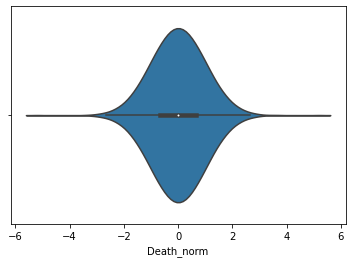

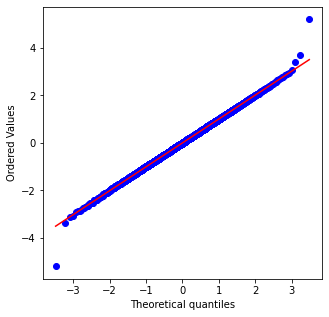

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:2357: UserWarning: n_quantiles (1000) is greater than the total number of samples (921). n_quantiles is set to n_samples.
  % (self.n_quantiles, n_samples))
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


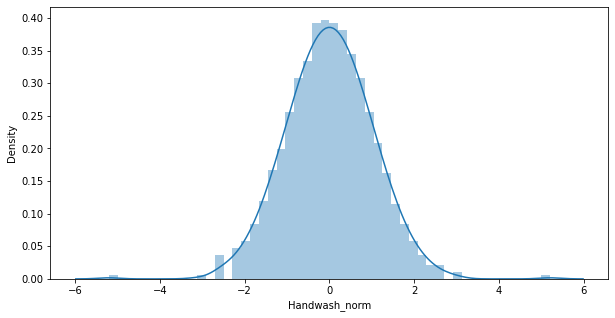

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


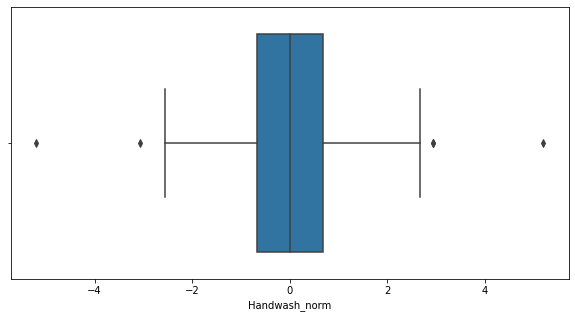

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


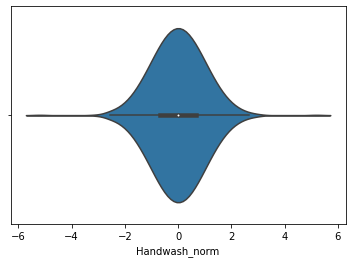

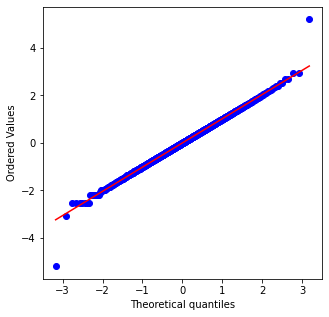

In [205]:
for dframe in dframes:
  for col in numcols(dframe):
    col_norm = col + SUFFIX_NORM
    dframe[col_norm] =  transform_to_norm(dframe[col])
    contplot(dframe[col_norm])

In [206]:
df_merged = reduce(lambda left,right: pd.merge(left, right, on=['Location','Year','Gender'], how='outer'), dframes)
display(df_merged)

,Location,Year,Gender,Tobacco,Tobacco_norm,Alcohol,Alcohol_norm,Water,Water_norm,Poison,Poison_norm,Death,Death_norm,Handwash,Handwash_norm
0,Albania,2018,Both sexes,29.2,0.376283,7.17,0.432743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,2018,Male,50.5,1.509656,11.63,0.949547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,2018,Female,7.9,-0.981540,2.68,-0.397918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,2017,Both sexes,29.3,0.383024,NaN,NaN,10.12,-0.099274,NaN,NaN,NaN,NaN,NaN,NaN
4,Albania,2017,Male,50.6,1.517545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6830,Turkmenistan,2016,Female,NaN,NaN,NaN,NaN,NaN,NaN,0.59,-0.128317,22.9,0.381675,NaN,NaN
6831,Venezuela (Bolivarian Republic of),2016,Male,NaN,NaN,NaN,NaN,NaN,NaN,0.39,-0.497809,21.8,0.207223,NaN,NaN
6832,Venezuela (Bolivarian Republic of),2016,Female,NaN,NaN,NaN,NaN,NaN,NaN,0.19,-1.269664,14.5,-0.868016,NaN,NaN
6833,Viet Nam,2016,Male,NaN,NaN,NaN,NaN,NaN,NaN,1.71,0.540882,23.4,0.466803,NaN,NaN


# Preprocess: Explore

In [207]:
df = df_merged.copy()
describeframe(df) # see custom method definition, contains descriptive statistics of the frame

,Location,Year,Gender,Tobacco,Tobacco_norm,Alcohol,Alcohol_norm,Water,Water_norm,Poison,Poison_norm,Death,Death_norm,Handwash,Handwash_norm
0,Albania,2018,Both sexes,29.2,0.376283,7.17,0.432743,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Albania,2018,Male,50.5,1.509656,11.63,0.949547,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Albania,2018,Female,7.9,-0.981540,2.68,-0.397918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Albania,2017,Both sexes,29.3,0.383024,NaN,NaN,10.12,-0.099274,NaN,NaN,NaN,NaN,NaN,NaN
4,Albania,2017,Male,50.6,1.517545,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6835 entries, 0 to 6834
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Location       6835 non-null   object 
 1   Year           6835 non-null   object 
 2   Gender         6835 non-null   object 
 3   Tobacco        4023 non-null   float64
 4   Tobacco_norm   4023 non-null   float64
 5   Alcohol        2787 non-null   float64
 6   Alcohol_norm   2787 non-null   float64
 7   Water          3455 non-null   float64
 8   Water_norm     3455 non-null   float64
 9   Poison         2745 non-null   float64
 10  Poison_norm    2745 non-null   float64
 11  Death          2745 non-null   float64
 12  Death_norm     2745 non-null   float64
 13  Handwash       921 non-null    float64
 14  Handwash_norm  921 non-null    float64
dtypes: float64(12), object(3)
memory usage: 854.4+ KB


,Location,Year,Gender,Tobacco,Tobacco_norm,Alcohol,Alcohol_norm,Water,Water_norm,Poison,Poison_norm,Death,Death_norm,Handwash,Handwash_norm
count,6835,6835,6835,4023.000000,4023.000000,2787.000000,2787.000000,3455.000000,3455.000000,2745.000000,2745.000000,2745.000000,2745.000000,921.000000,921.000000
unique,195,19,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,Portugal,2005,Both sexes,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,37,576,3657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,24.807159,-0.004385,6.158478,-0.001591,22.152897,-0.522530,1.417948,-0.001401,20.644809,-0.000146,52.498089,0.000215
std,NaN,NaN,NaN,15.745702,1.021547,5.584142,1.012823,23.987570,2.062714,1.639441,1.008173,6.884163,1.007666,32.774406,1.021271
min,NaN,NaN,NaN,0.000000,-5.199338,0.000000,-5.199338,0.000000,-5.199338,0.039000,-5.199338,4.700000,-5.199338,0.000000,-5.199338
0.1%,NaN,NaN,NaN,0.000000,-5.199338,0.000472,-3.527662,0.000000,-5.199338,0.044744,-3.080899,5.774400,-3.086608,0.570400,-3.236100
0.5%,NaN,NaN,NaN,0.400000,-2.511791,0.005930,-2.578811,0.000000,-5.199338,0.066000,-2.575483,7.072000,-2.573594,1.000000,-2.546864
1%,NaN,NaN,NaN,0.600000,-2.325972,0.019000,-2.325972,0.000000,-5.199338,0.083880,-2.325366,7.500000,-2.325972,2.280000,-2.209010


Standard error


Tobacco          0.248249
Tobacco_norm     0.016106
Alcohol          0.105776
Alcohol_norm     0.019185
Water            0.408096
Water_norm       0.035093
Poison           0.031291
Poison_norm      0.019243
Death            0.131395
Death_norm       0.019233
Handwash         1.079953
Handwash_norm    0.033652
dtype: float64

Coefficient of variation


Tobacco              63.472412
Tobacco_norm     -23298.369500
Alcohol              90.674067
Alcohol_norm     -63645.628725
Water               108.281864
Water_norm         -394.755294
Poison              115.620691
Poison_norm      -71973.331546
Death                33.345734
Death_norm      -692293.849919
Handwash             62.429713
Handwash_norm    475005.850155
dtype: float64

Range


Tobacco          91.000000
Tobacco_norm     10.398675
Alcohol          31.960000
Alcohol_norm     10.398675
Water            89.870000
Water_norm       10.398675
Poison           25.951000
Poison_norm      10.398675
Death            47.000000
Death_norm       10.398675
Handwash         98.970000
Handwash_norm    10.398675
dtype: float64

Interquartile range


Tobacco          22.000000
Tobacco_norm      1.352135
Alcohol           7.590000
Alcohol_norm      1.347771
Water            38.565000
Water_norm        1.349405
Poison            1.830000
Poison_norm       1.352135
Death             8.900000
Death_norm        1.342690
Handwash         67.760000
Handwash_norm     1.348980
dtype: float64

Skewness


Tobacco          0.585256
Tobacco_norm    -0.197449
Alcohol          1.152737
Alcohol_norm    -0.071349
Water            0.918685
Water_norm      -1.452358
Poison           3.037007
Poison_norm     -0.006304
Death            0.523159
Death_norm       0.006441
Handwash        -0.053897
Handwash_norm    0.004508
dtype: float64

Curtosis


Tobacco           0.130816
Tobacco_norm      1.181334
Alcohol           0.881432
Alcohol_norm      0.696585
Water            -0.425522
Water_norm        1.076326
Poison           23.671754
Poison_norm       0.340224
Death             0.677810
Death_norm        0.379558
Handwash         -1.575109
Handwash_norm     1.038947
dtype: float64

## Data types

Goal is to have types:

- object for string
- numPy's float64 for all numbers (to take advantage of NaN)

In [208]:
for col in ['Location','Gender','Year']:
  [print(v) for v in df[col] if type(v)!=str];

Nothing printed means the types are ok.

## Categorical + Bivariate analysis

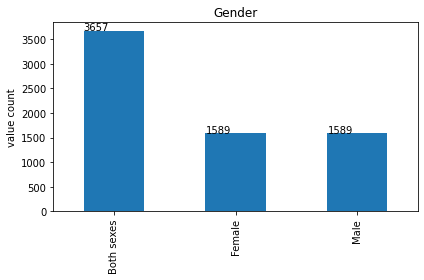

In [209]:
col = 'Gender'
bar(df[col], title=col)

<font color='red'>RED</font> Female  
<font color='blue'>BLUE</font> Male  
<font color='green'>GREEN</font> Mixed

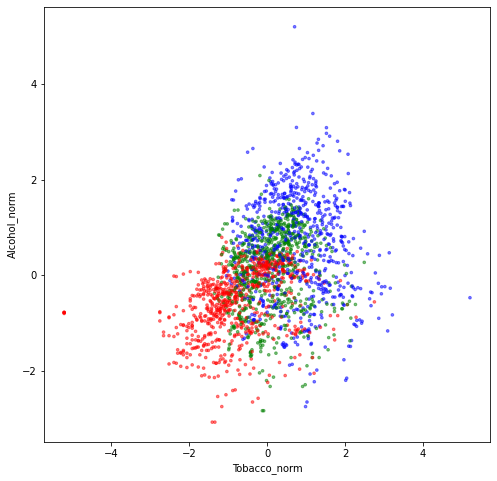

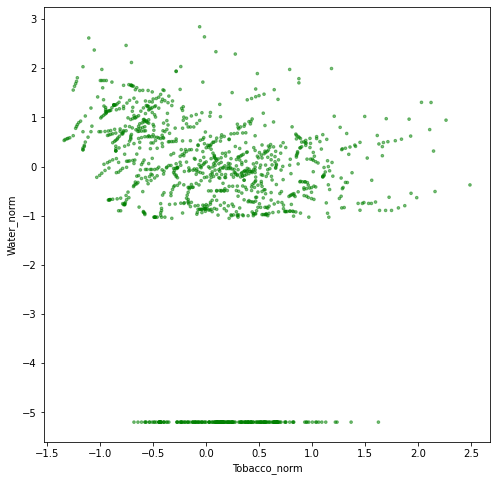

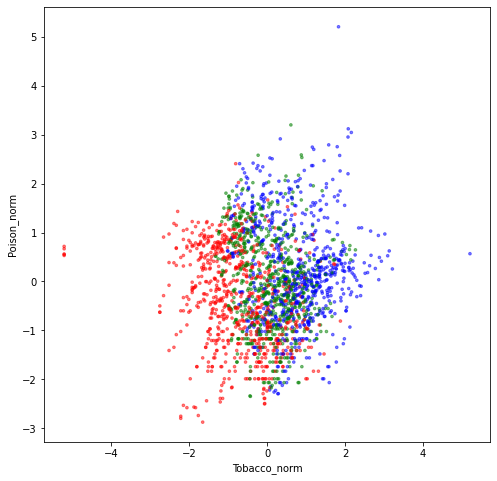

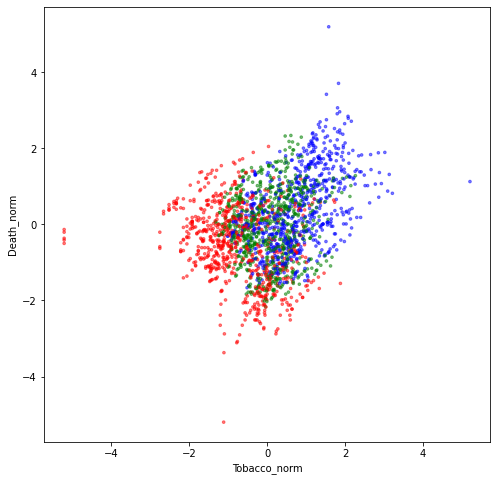

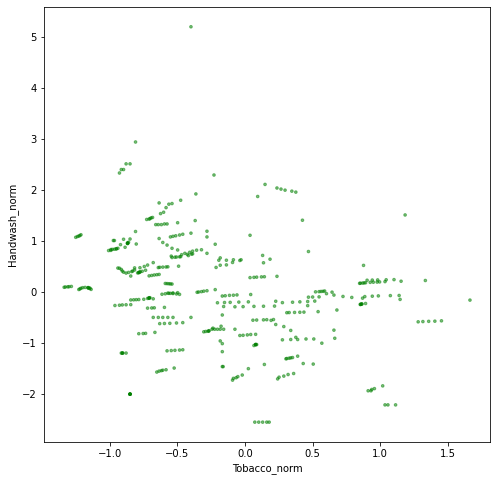

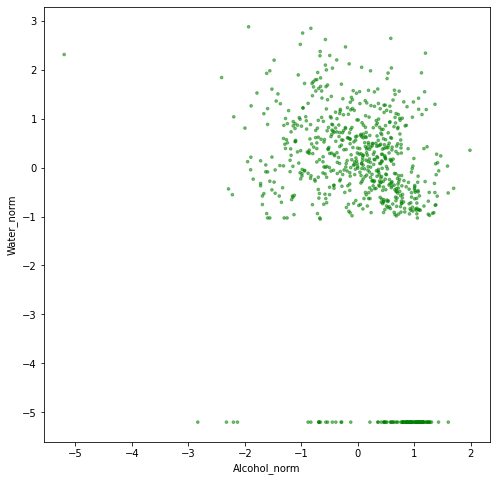

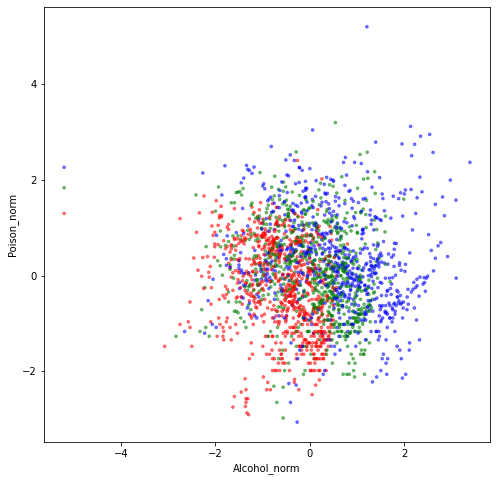

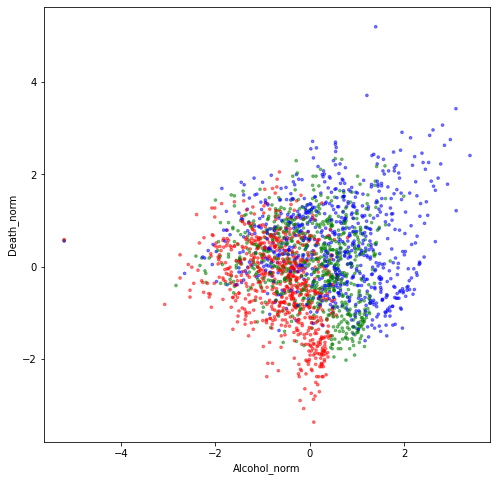

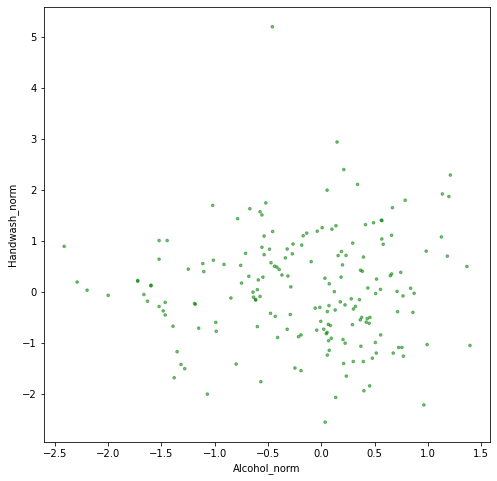

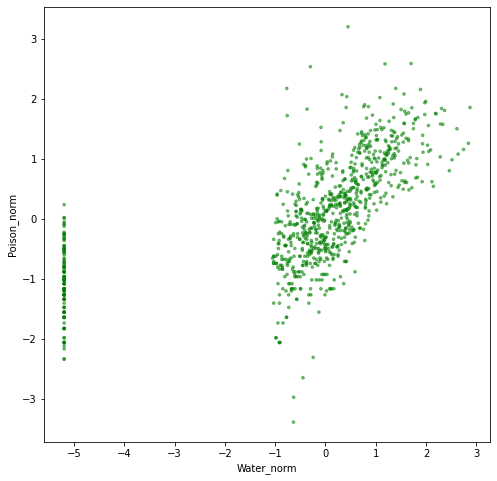

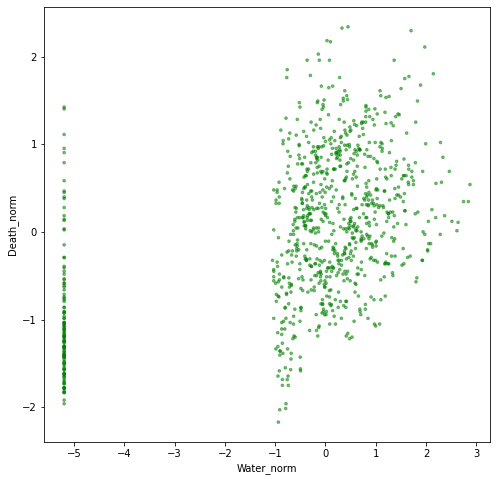

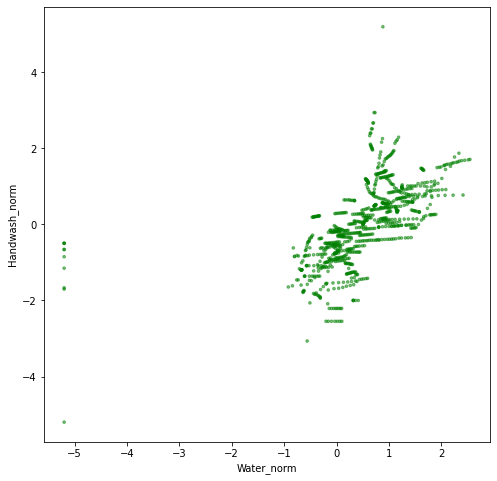

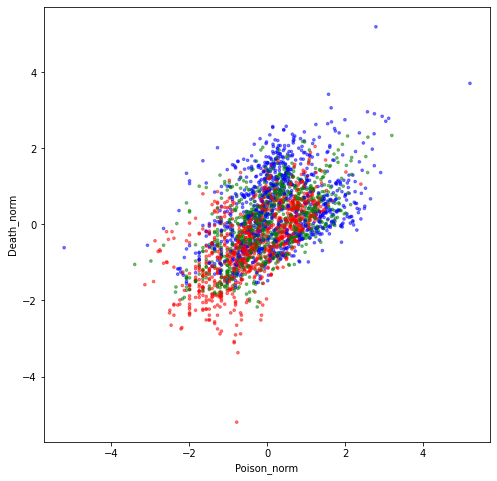

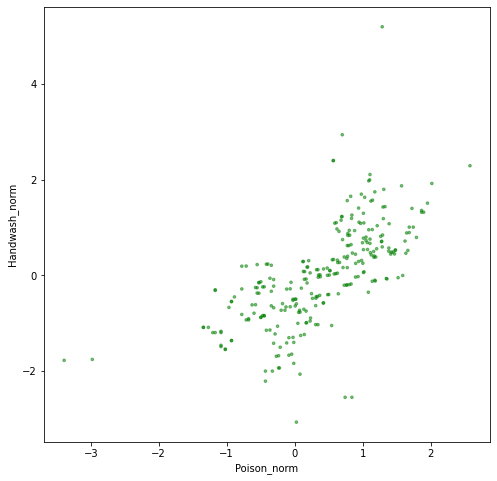

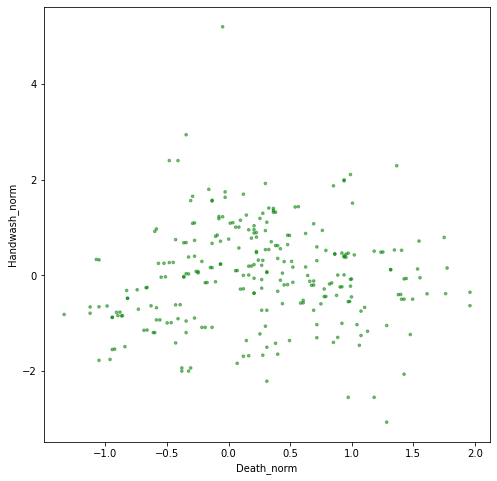

In [210]:
color = df['Gender'].apply(lambda x: 'red' if x=='Female' else ('blue' if x=='Male' else 'green'))
[scatter(df[colx], df[coly], color_series=color) for colx,coly in combinations(numcols(df, norm_only=True), r=2)];

Positive linear correlation
- Death - Tobacco
- Death - Alcohol
- Poison - Water
- Death - Water
- Handwash - Water
- Death - Poison
- Handwash - Poison

Dependency
- Death on Tobacco, Alcohol, Water, Poison
- Poison on Handwash

Before an initial experiment that follows, we drop
- Handwash, because it is only second-line indicator of Death
- Water because of the shape of distribution

In [211]:
df.drop(['Tobacco', 'Alcohol', 'Water', 'Water_norm', 'Poison', 'Death', 'Handwash', 'Handwash_norm'], axis=1, inplace=True)

Hypotheses  
H1 Death changes lineary with Tobacco  
H2 Death changes lineary with Alcohol  
H3 Death changes lineary with Poison  
H4 Death changes with Tobacco and Alcohol and Poison  
H5 Female Death changes with Tobacco and Alcohol and Poison

In [212]:
describeframe(df)

,Location,Year,Gender,Tobacco_norm,Alcohol_norm,Poison_norm,Death_norm
0,Albania,2018,Both sexes,0.376283,0.432743,NaN,NaN
1,Albania,2018,Male,1.509656,0.949547,NaN,NaN
2,Albania,2018,Female,-0.981540,-0.397918,NaN,NaN
3,Albania,2017,Both sexes,0.383024,NaN,NaN,NaN
4,Albania,2017,Male,1.517545,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
Int64Index: 6835 entries, 0 to 6834
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Location      6835 non-null   object 
 1   Year          6835 non-null   object 
 2   Gender        6835 non-null   object 
 3   Tobacco_norm  4023 non-null   float64
 4   Alcohol_norm  2787 non-null   float64
 5   Poison_norm   2745 non-null   float64
 6   Death_norm    2745 non-null   float64
dtypes: float64(4), object(3)
memory usage: 427.2+ KB


,Location,Year,Gender,Tobacco_norm,Alcohol_norm,Poison_norm,Death_norm
count,6835,6835,6835,4023.000000,2787.000000,2745.000000,2745.000000
unique,195,19,3,NaN,NaN,NaN,NaN
top,Portugal,2005,Both sexes,NaN,NaN,NaN,NaN
freq,37,576,3657,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,-0.004385,-0.001591,-0.001401,-0.000146
std,NaN,NaN,NaN,1.021547,1.012823,1.008173,1.007666
min,NaN,NaN,NaN,-5.199338,-5.199338,-5.199338,-5.199338
0.1%,NaN,NaN,NaN,-5.199338,-3.527662,-3.080899,-3.086608
0.5%,NaN,NaN,NaN,-2.511791,-2.578811,-2.575483,-2.573594
1%,NaN,NaN,NaN,-2.325972,-2.325972,-2.325366,-2.325972


Standard error


Tobacco_norm    0.016106
Alcohol_norm    0.019185
Poison_norm     0.019243
Death_norm      0.019233
dtype: float64

Coefficient of variation


Tobacco_norm    -23298.369500
Alcohol_norm    -63645.628725
Poison_norm     -71973.331546
Death_norm     -692293.849919
dtype: float64

Range


Tobacco_norm    10.398675
Alcohol_norm    10.398675
Poison_norm     10.398675
Death_norm      10.398675
dtype: float64

Interquartile range


Tobacco_norm    1.352135
Alcohol_norm    1.347771
Poison_norm     1.352135
Death_norm      1.342690
dtype: float64

Skewness


Tobacco_norm   -0.197449
Alcohol_norm   -0.071349
Poison_norm    -0.006304
Death_norm      0.006441
dtype: float64

Curtosis


Tobacco_norm    1.181334
Alcohol_norm    0.696585
Poison_norm     0.340224
Death_norm      0.379558
dtype: float64

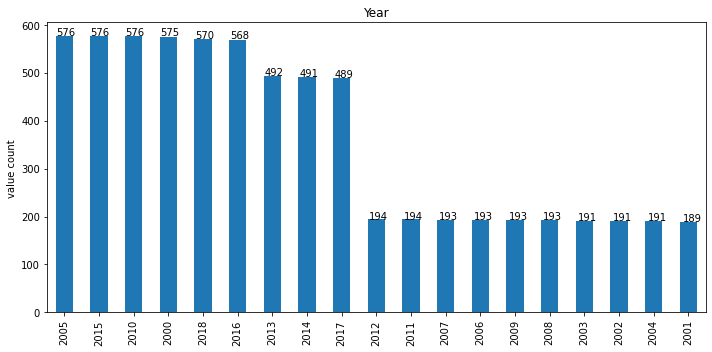

In [213]:
col = 'Year'
bar(df[col], title=col, figsize=(10,5))

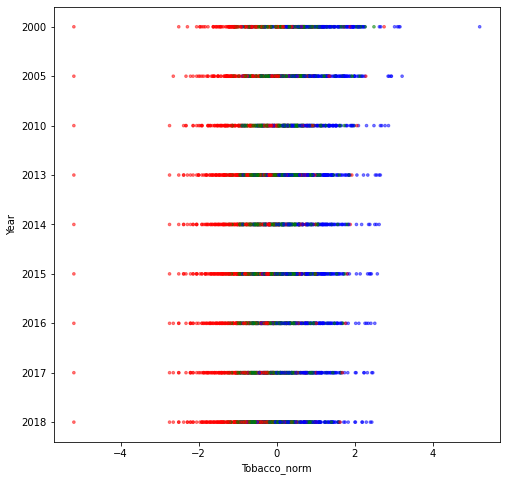

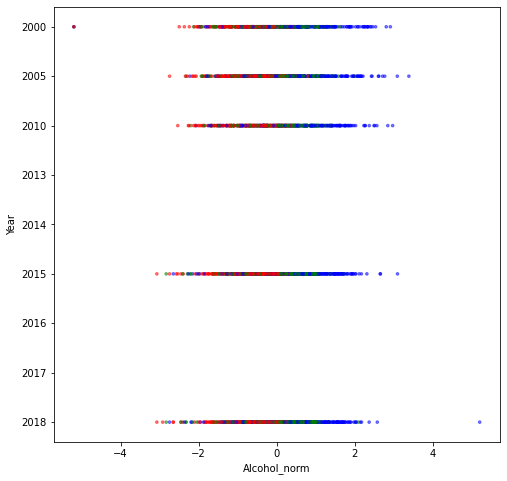

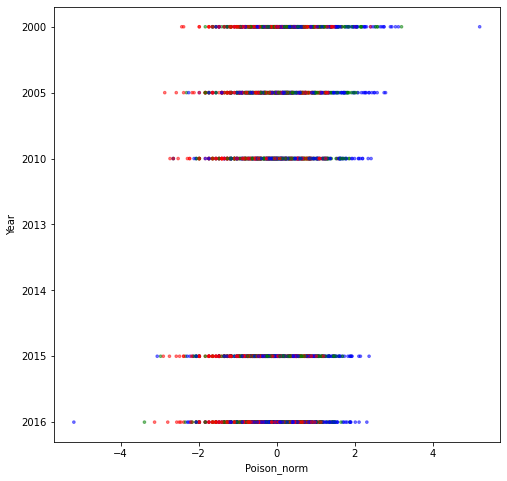

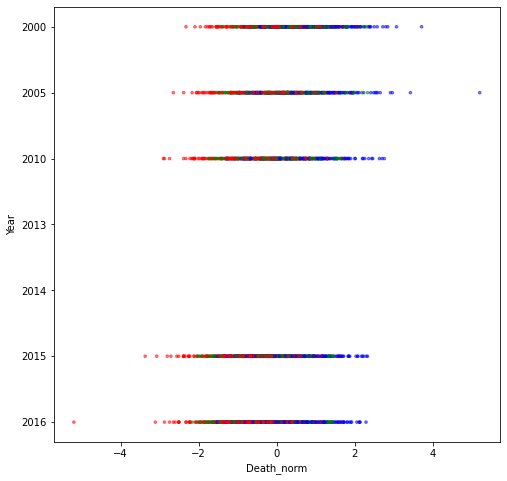

In [214]:
[scatter(df[colx], df['Year'], color_series=color) for colx in numcols(df)];

For all variables, each year, male gender tends to have higher values than female, i.e. more negative real life situation

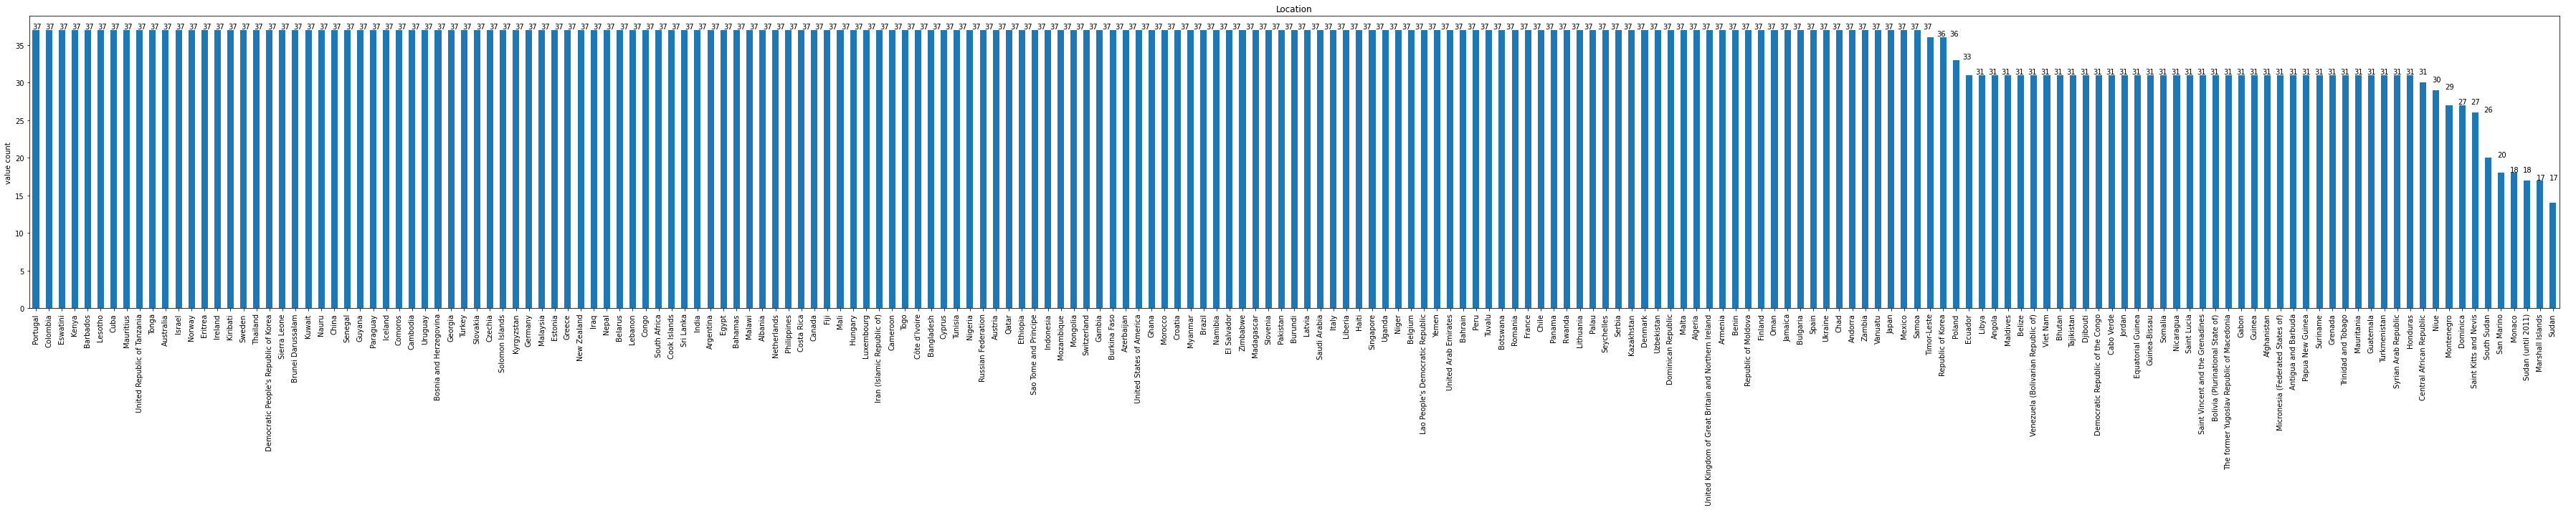

In [215]:
col = 'Location'
bar(df[col], title=col, figsize=(50,10))

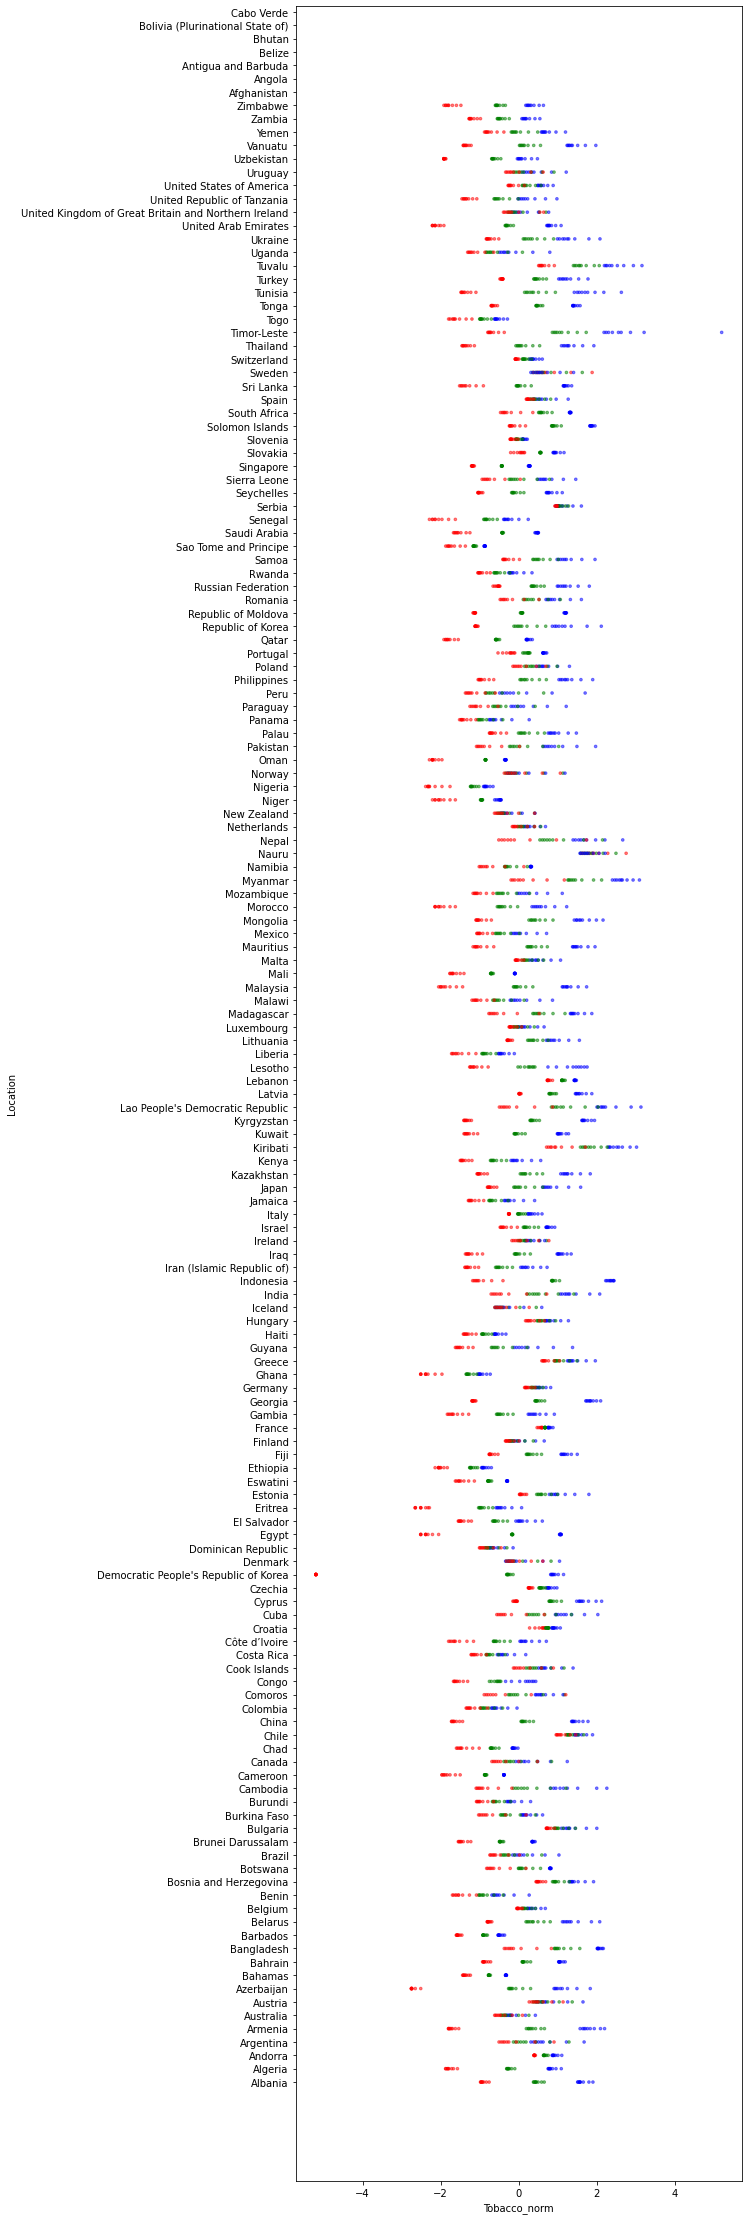

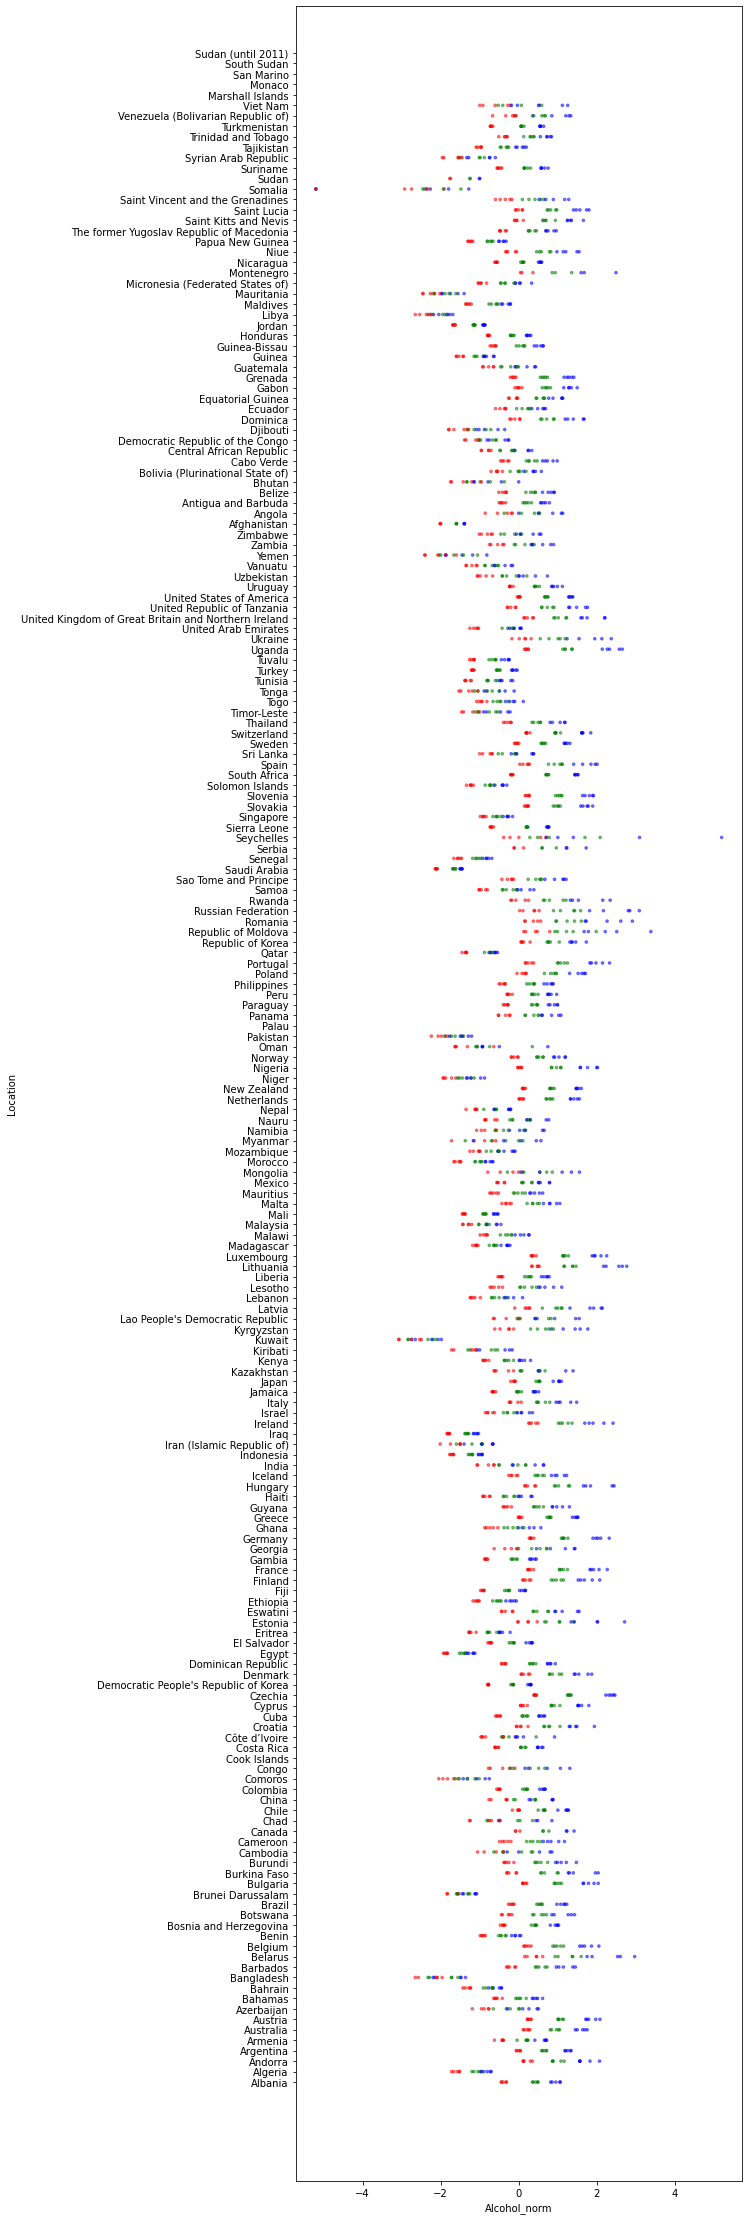

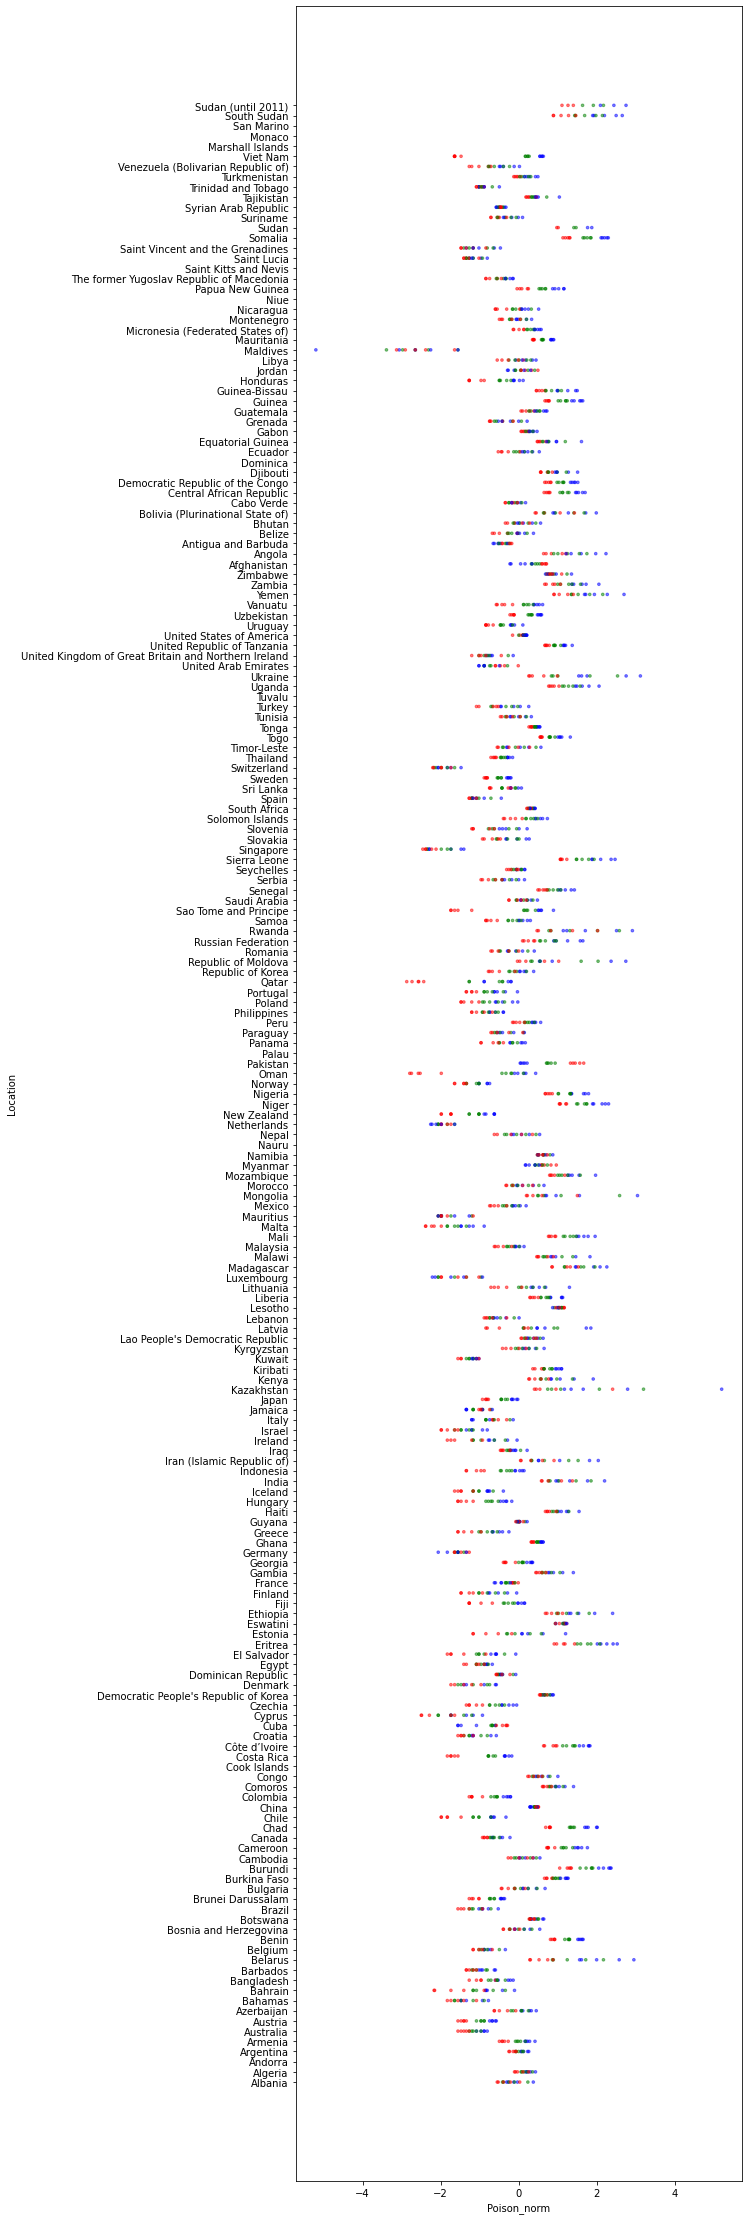

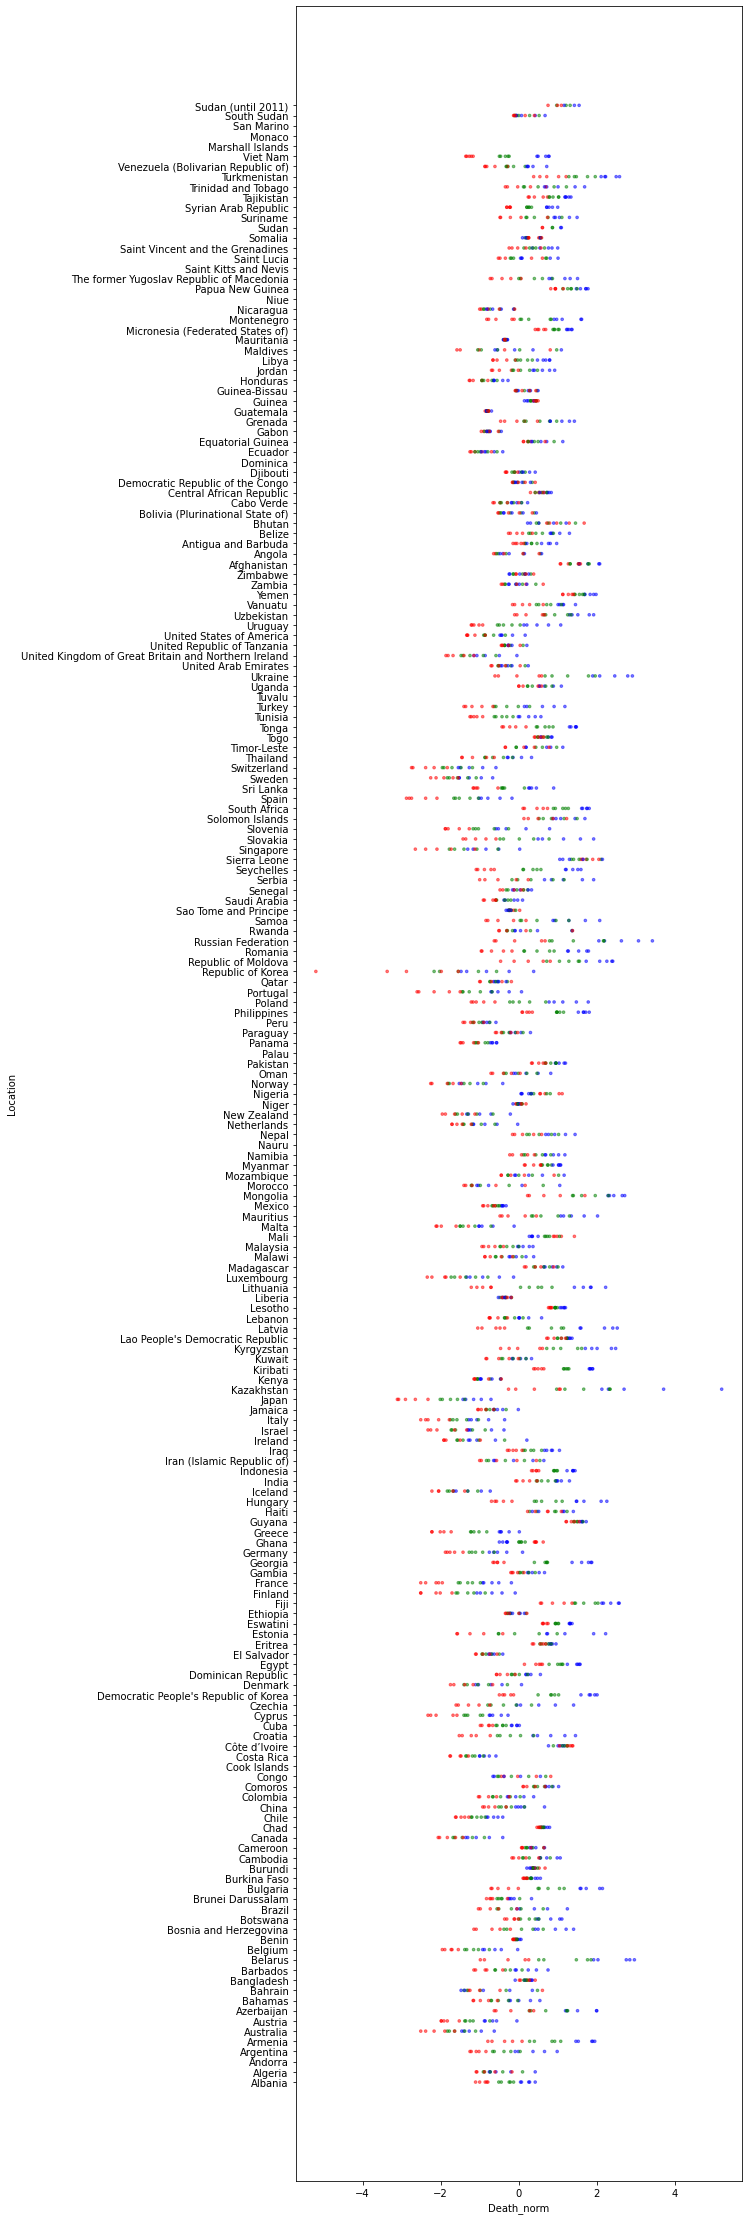

In [216]:
[scatter(df[colx], df['Location'], color_series=color, figsize=[8,40]) for colx in numcols(df)];

For all variables, each country, male gender tends to have higher values than female, i.e. more negative real life situation

## Numeric

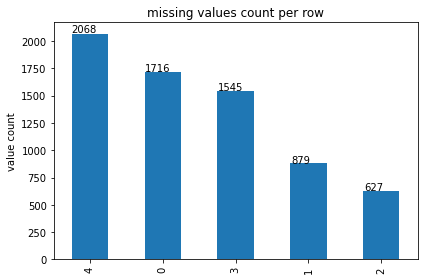

In [217]:
bar(df[numcols(df)].applymap(lambda x: np.nan if type(x)==str and x=='?' else x).isnull().sum(axis=1), title='missing values count per row')

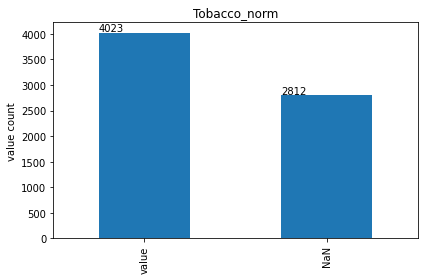

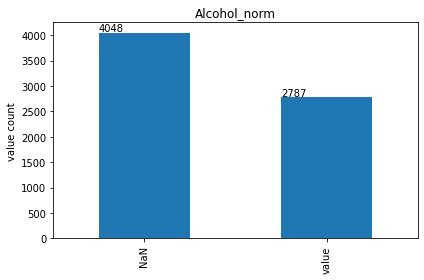

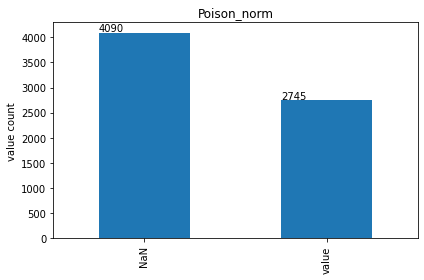

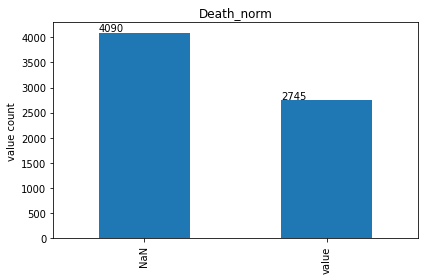

In [218]:
[bar(df[col].apply(lambda x: 'NaN' if pd.isnull(x) else 'value'), title=col) for col in numcols(df)];

## Correlation

Since we work with linear correlation, we can choose Peason as correlation coefficient.

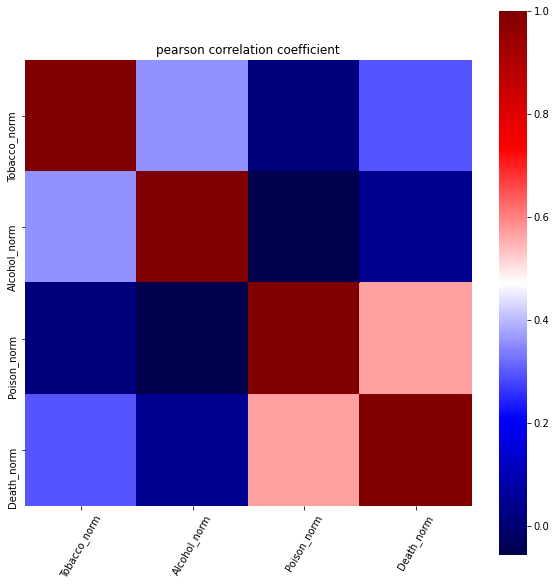

,Tobacco_norm,Alcohol_norm,Poison_norm,Death_norm
Tobacco_norm,1.000000,0.360719,NaN,NaN
Alcohol_norm,0.360719,1.000000,NaN,NaN
Poison_norm,NaN,NaN,1.000000,0.570939
Death_norm,NaN,NaN,0.570939,1.000000


In [219]:
corr_num = df[numcols(df)].corr('pearson')
hm(corr_num, xlabels=corr_num.columns, ylabels=corr_num.columns, title='{} correlation coefficient'.format('pearson'))
display(corr_num[corr_num.applymap(lambda x: np.absolute(x) > .3)])

Apart from a single pair, no possible correlation is identified. Even the one is not significant. But we continue to analyze the variables.

# Outlier substitution

Here is a custom method for outlier substitution, to demonstrate what would be used in case necessary. After deeper look at data, removing extreme values did not make any sense, since data were clear (% zero to 100).

In [220]:
def remove_outlier(series, left_quantile=None, right_quantile=None):
  if left_quantile:
    left_quantile_val = series.quantile(left_quantile)
    print('Remove smaller than', left_quantile_val)
  if right_quantile:
    right_quantile_val = series.quantile(right_quantile)
    print('Remove greater than', right_quantile_val)
  if left_quantile:
    print('Removed:', series[series < left_quantile_val])
    series = series.apply(lambda x: max(left_quantile_val, x))
  if right_quantile:
    print('Removed:', series[series > right_quantile_val])
    series = series.apply(lambda x: min(right_quantile_val, x))
  return series

# Linear Regression

In [221]:
def lin_reg(X_train, X_test, y_train, y_test, xlabel=None, ylabel=None, plot=True):
  lr = LinearRegression().fit(X=X_train, y=y_train)
  print('intercept', lr.intercept_)
  print('slope', lr.coef_)
  print('R^2 score', lr.score(X_train, y_train))

  y_pred = lr.predict(X_test) # = lr.intercept_ + lr.coef_[0] * X_test

  N = X_train.shape[0]
  mse = mean_squared_error(y_test, y_pred)
  #rmse = math.sqrt(mse / N)
  rse = math.sqrt(mse / (N-2))
  print('RSE', rse)

  if plot:
    plt.figure()
    plt.scatter(X_test, y_test, color='black')
    plt.title('Test Data')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(X_test, y_pred, color='red', linewidth=3)
    plt.show()

We perform linear regression based on listed hypotheses.

H3 Death changes lineary with Poison  

intercept -0.010554222989171825
slope [0.54776913]
R^2 score 0.34415195378771757
RSE 0.027633763597105246


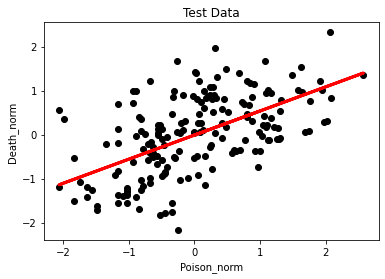

In [222]:
gender = 'Both sexes'
col_X = ['Poison_norm']
df1 = df[df['Gender'] == gender][col_X + ['Death_norm']].copy()
df1.dropna(inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df1[col_X], df1['Death_norm'], test_size=.2, random_state=42)

lin_reg(X_train, X_test, y_train, y_test, xlabel=col_X[0], ylabel='Death_norm')

H2 Death changes lineary with Alcohol  


intercept 0.07107709855326615
slope [-0.20555219]
R^2 score 0.04330118902593772
RSE 0.03516748074372021


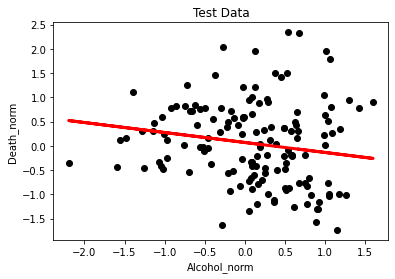

In [223]:
gender = 'Both sexes'
col_X = ['Alcohol_norm']
df1 = df[df['Gender'] == gender][col_X + ['Death_norm']].copy()
df1.dropna(inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df1[col_X], df1['Death_norm'], test_size=.2, random_state=42)

lin_reg(X_train, X_test, y_train, y_test, xlabel=col_X[0], ylabel='Death_norm')

H1 Death changes lineary with Tobacco  


intercept -0.06403523683580375
slope [0.20814967]
R^2 score 0.02275284669707234
RSE 0.0355375297026745


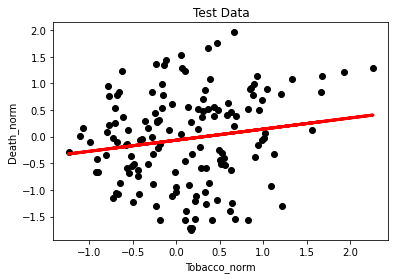

In [224]:
gender = 'Both sexes'
col_X = ['Tobacco_norm']
df1 = df[df['Gender'] == gender][col_X + ['Death_norm']].copy()
df1.dropna(inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df1[col_X], df1['Death_norm'], test_size=.2, random_state=42)

lin_reg(X_train, X_test, y_train, y_test, xlabel=col_X[0], ylabel='Death_norm')

H4 Death changes with Tobacco and Alcohol and Poison  


In [225]:
gender = 'Both sexes'
col_X = ['Poison_norm', 'Alcohol_norm', 'Tobacco_norm']
df1 = df[df['Gender'] == gender][col_X + ['Death_norm']].copy()
df1.dropna(inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df1[col_X], df1['Death_norm'], test_size=.2, random_state=42)

lin_reg(X_train, X_test, y_train, y_test, xlabel=col_X[0], ylabel='Death_norm', plot=False)

intercept -0.04696442578662646
slope [ 0.67272534 -0.10566533  0.3559674 ]
R^2 score 0.5226422300630797
RSE 0.03132106370195067


Additionally, we experiment with t-distributed stochastic neighbor embedding. We aim to find out whether data after dimension reduction gives results comparable to original data.

perplexity 5
t-SNE completed with KL divergence 0.9929844737052917
intercept 0.01858101
slope [-0.00154298]
R^2 score 0.020678385472316596
RSE 0.036975252896797366


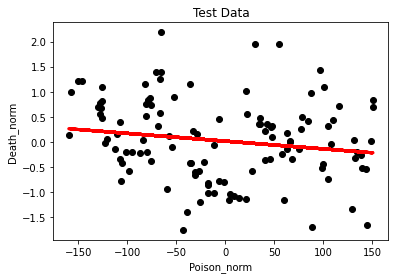

perplexity 10
t-SNE completed with KL divergence 0.9408448934555054
intercept 0.011215685
slope [-0.00356247]
R^2 score 0.06919418504154806
RSE 0.037496351987777836


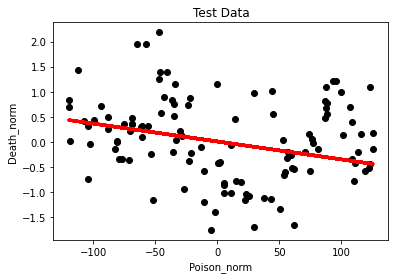

perplexity 15
t-SNE completed with KL divergence 0.9897922277450562
intercept 0.016042605
slope [-0.00876987]
R^2 score 0.27793161340400696
RSE 0.03731710704546413


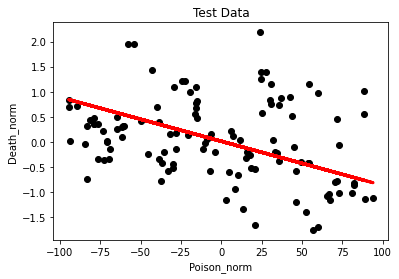

perplexity 20
t-SNE completed with KL divergence 1.0371915102005005
intercept 0.023019044
slope [-0.01285646]
R^2 score 0.3281386582836037
RSE 0.036480335421390196


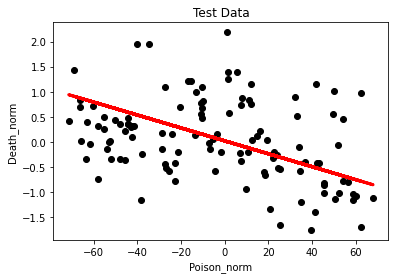

perplexity 25
t-SNE completed with KL divergence 1.0073193311691284
intercept -0.0030018333
slope [-0.01521994]
R^2 score 0.3229279261844492
RSE 0.03585301744724619


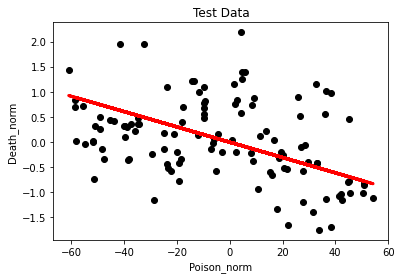

perplexity 30
t-SNE completed with KL divergence 0.9802058935165405
intercept 0.017431768
slope [0.01846053]
R^2 score 0.28349971277480757
RSE 0.03665786012720331


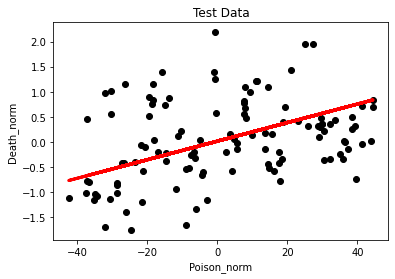

In [226]:
for perp in [5,10,15,20,25,30]:
  print('perplexity', perp)
  tsne = TSNE(n_components=1, perplexity=perp, n_iter=2000)

  df1_tsne = tsne.fit_transform(df1[col_X])
  print('t-SNE completed with KL divergence {}'.format(tsne.kl_divergence_))
  X_train, X_test, y_train, y_test = train_test_split(df1_tsne, df1['Death_norm'], test_size=.2, random_state=42)

  lin_reg(X_train, X_test, y_train, y_test, xlabel=col_X[0], ylabel='Death_norm')

In [227]:
gender = 'Male'
col_X = ['Poison_norm', 'Alcohol_norm', 'Tobacco_norm']
df1 = df[df['Gender'] == gender][col_X + ['Death_norm']].copy()
df1.dropna(inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df1[col_X], df1['Death_norm'], test_size=.2, random_state=42)

lin_reg(X_train, X_test, y_train, y_test, xlabel=col_X[0], ylabel='Death_norm', plot=False)

intercept -0.21863112747635055
slope [0.54309267 0.12749636 0.56746125]
R^2 score 0.4991614358459294
RSE 0.03467775892647992


H5 Female Death changes with Tobacco and Alcohol and Poison

In [228]:
gender = 'Female'
col_X = ['Poison_norm', 'Alcohol_norm', 'Tobacco_norm']
df1 = df[df['Gender'] == gender][col_X + ['Death_norm']].copy()
df1.dropna(inplace=True)

X_train, X_test, y_train, y_test = train_test_split(df1[col_X], df1['Death_norm'], test_size=.2, random_state=42)

lin_reg(X_train, X_test, y_train, y_test, xlabel=col_X[0], ylabel='Death_norm', plot=False)

intercept -0.5263017392047538
slope [ 0.61842991 -0.39255388 -0.03631244]
R^2 score 0.5489330026655934
RSE 0.029563393366268488


Since sklearn's linear regression does not calculate pvalue, here we demonstrate how to do it.

In [229]:
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             Death_norm   R-squared:                       0.549
Model:                            OLS   Adj. R-squared:                  0.546
Method:                 Least Squares   F-statistic:                     183.8
Date:                Fri, 07 May 2021   Prob (F-statistic):           6.12e-78
Time:                        17:32:14   Log-Likelihood:                -468.68
No. Observations:                 457   AIC:                             945.4
Df Residuals:                     453   BIC:                             961.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.5263      0.048    -10.885   

pvalue < 5% means results are not significant.

In [230]:
gender = 'Female'
col_X = ['Poison_norm', 'Alcohol_norm', 'Tobacco_norm']
df1 = df[df['Gender'] == gender][col_X + ['Death_norm']].copy()
df1.dropna(subset=['Death_norm'], inplace=True)

CONCLUSION  
None of hypotheses rejected null hypothesis, meaning linear correlation would be significant. However, we have demonstarted the working process with linear regression, plus t-SNE has been used as well.  
Dimensionality reduction by t-SNE led to information loss to larger extend than desired.

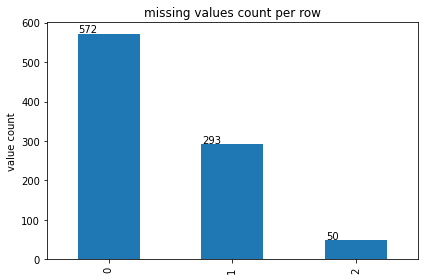

In [231]:
bar(df1[numcols(df1)].applymap(lambda x: np.nan if type(x)==str and x=='?' else x).isnull().sum(axis=1), title='missing values count per row')

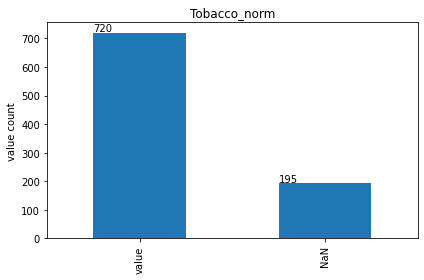

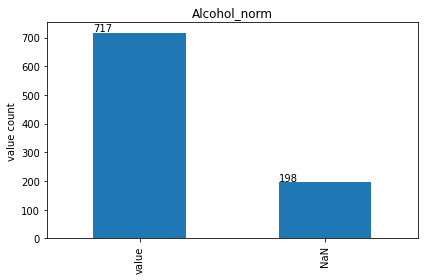

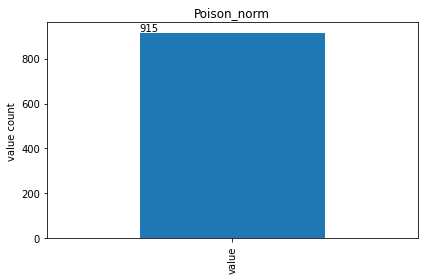

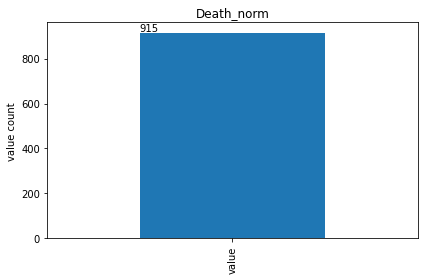

In [232]:
[bar(df1[col].apply(lambda x: 'NaN' if pd.isnull(x) else 'value'), title=col) for col in numcols(df)];

# Imputing

In [233]:
for strategy in ['mean', 'median']:
  print('\tstrategy', strategy)
  imputer = SimpleImputer(missing_values=np.nan, strategy=strategy).fit(df1[col_X])
  dfX_imp = imputer.transform(df1[col_X])

  X_train, X_test, y_train, y_test = train_test_split(dfX_imp, df1['Death_norm'], test_size=.2, random_state=42)

  lin_reg(X_train, X_test, y_train, y_test, xlabel=col_X[0], ylabel='Death_norm', plot=False)

	strategy mean
intercept -0.4944448889884637
slope [ 0.59007998 -0.2772135  -0.06294515]
R^2 score 0.4853306276879446
RSE 0.02904664722992445
	strategy median
intercept -0.4957627543679378
slope [ 0.58733701 -0.28090102 -0.0674446 ]
R^2 score 0.4871813135097368
RSE 0.02891880031301539


All imputing strategies produced worse model (R2score) than skipping rows with missing values.

# Bayes

The only pair that has proved to be actually related were smoking tobacco and death. We focus on female gender again and provide a simple example working with bayes probabilities.

In [234]:
df2 = df[df['Gender'] != 'Both sexes'].copy()
df2.dropna(inplace=True)
TRESHOLD_TOBACCO = 0.
TRESHOLD_DEATH = 0.
df2['smokes'] = df2['Tobacco_norm'].apply(lambda x: x > TRESHOLD_TOBACCO)
df2['dies'] = df2['Death_norm'].apply(lambda x: x > TRESHOLD_DEATH)

In [235]:
df3 = df2[['Gender', 'smokes', 'dies']]
df3.head()

,Gender,smokes,dies
10,Male,True,True
11,Female,False,False
19,Male,True,True
20,Female,False,False
22,Male,True,True


P(smoke)

In [236]:
N = df3.index.size
percent(df3[df3['smokes'] == True].index.size / N)

'52.27 %'

P(no smoke)

In [237]:
percent(df3[df3['smokes'] == False].index.size / N)

'47.73 %'

P(smoke | Male)



In [238]:
N = df3[df3['Gender'] == 'Male'].index.size
percent(df3[(df3['Gender'] == 'Male') & (df3['smokes'] == True)].index.size / N)

'81.29 %'

P(no smoke | Male)


In [239]:
percent(df3[(df3['Gender'] == 'Male') & (df3['smokes'] == False)].index.size / N)

'18.71 %'

P(smoke | Female)


In [240]:
N = df3[df3['Gender'] == 'Female'].index.size
percent(df3[(df3['Gender'] == 'Female') & (df3['smokes'] == True)].index.size / N)

'23.25 %'

P(no smoke | Female)


In [241]:
percent(df3[(df3['Gender'] == 'Female') & (df3['smokes'] == False)].index.size / N)

'76.75 %'

P(die | smoke | Female)

In [242]:
N = df3[(df3['Gender'] == 'Female') & (df3['smokes'] == True)].index.size
percent(df3[(df3['Gender'] == 'Female') & (df3['smokes'] == True) & (df3['dies'] == True)].index.size / N)

'21.8 %'

P(no die | smoke | Female)


In [243]:
percent(df3[(df3['Gender'] == 'Female') & (df3['smokes'] == True) & (df3['dies'] == False)].index.size / N)

'78.2 %'

P(die | no smoke | Female)

In [244]:
N = df3[(df3['Gender'] == 'Female') & (df3['smokes'] == False)].index.size
percent(df3[(df3['Gender'] == 'Female') & (df3['smokes'] == False) & (df3['dies'] == True)].index.size / N)

'37.36 %'

P(no die | no smoke | Female)

In [245]:
percent(df3[(df3['Gender'] == 'Female') & (df3['smokes'] == False) & (df3['dies'] == False)].index.size / N)

'62.64 %'

Outputs give answer to questions that require conditional probability.  

For example, in our case, we have found out death of individuals provided they smoke provided they are female is only 21.8 %.